In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV # for cross-validation
from sklearn.metrics import matthews_corrcoef, mean_squared_error, r2_score, accuracy_score, confusion_matrix, average_precision_score, classification_report, f1_score, roc_auc_score, precision_score, recall_score # for measuring model performance
from sklearn.model_selection import cross_val_score
from scipy import stats as st
from sklearn.inspection import permutation_importance
from sklearn.base import clone 
from imblearn.over_sampling import SMOTE
from sklearn.inspection import plot_partial_dependence, PartialDependenceDisplay


# Reading initial data
data_ini = pd.read_csv('Tcruzi_data__.csv')

data_ini['infec'] = data_ini['Interpretacao_final'].replace(['negativo','positivo'],[0,1])
data_ini.dropna(subset=['infec'], inplace=True)
data_ini['roedor'] = data_ini['Group'].replace(['rodent','marsupial'],[1,0])
data_ini['marsupial'] = data_ini['Group'].replace(['rodent','marsupial'],[0,1])
data_ini['sexo'] = data_ini['sexo'].replace(['M','F'],[1,0])


############ NEW FEATURES ########################################################################

#----- morfo -------------------------------------
data_ini['cauda/corpo'] = data_ini['Cauda'] / data_ini['Corpo']
data_ini['cauda/corpo_median'] = data_ini['Cauda_median'] / data_ini['Corpo_median']
# replacing missing cauda/corpo with median (by species)
data_ini['cauda/corpo'].fillna(data_ini['cauda/corpo_median'], inplace=True)
# replacing missing peso with median (by species)
data_ini['Peso'].fillna(data_ini['Peso_median'], inplace=True)

data_ini['log_Peso']=np.log10(data_ini['Peso'])

#------ community -----------------------------------
g = data_ini.groupby('Comm_5km')
data_ini['ratio_roedor_5'] = g['roedor'].transform('sum') / g['roedor'].transform('count')
g = data_ini.groupby('Comm_3km')
data_ini['ratio_roedor_3'] = g['roedor'].transform('sum') / g['roedor'].transform('count')
g = data_ini.groupby('Comm_10km')
data_ini['ratio_roedor_10'] = g['roedor'].transform('sum') / g['roedor'].transform('count')

list_NAto0 = ['Fisher_alpha_3km','FEve_3km','Fisher_alpha_5km','FEve_5km','Fisher_alpha_10km','FEve_10km']; data_ini[list_NAto0]=data_ini[list_NAto0].fillna(0.)

#------ environment ---------------------------------------
data_ini['edge_prop_3km'] = data_ini['Edge_length_km_3km'] / np.sqrt(data_ini['total_area_sqkm_Comm_3km'])  # MODIFICADO: NEW EDGE
data_ini['edge_prop_5km'] = data_ini['Edge_length_km_5km'] / np.sqrt(data_ini['total_area_sqkm_Comm_5km'])  # MODIFICADO: NEW EDGE
data_ini['edge_prop_10km'] = data_ini['Edge_length_km_10km'] / np.sqrt(data_ini['total_area_sqkm_Comm_10km'])  # MODIFICADO: NEW EDGE
data_ini['edge_prop_3km'].fillna(0., inplace=True)
data_ini['edge_prop_5km'].fillna(0., inplace=True)
data_ini['edge_prop_10km'].fillna(0., inplace=True)
#data_ini['edge_cov_3km'] = data_ini['Edge_length_km_3km'] / np.sqrt(data_ini['ForCov_Area_Sqkm_3km'])
#data_ini['edge_cov_5km'] = data_ini['Edge_length_km_5km'] / np.sqrt(data_ini['ForCov_Area_Sqkm_5km'])
#data_ini['edge_cov_10km'] = data_ini['Edge_length_km_10km'] / np.sqrt(data_ini['ForCov_Area_Sqkm_10km'])
#data_ini['edge_cov_3km'].fillna(0., inplace=True)
#data_ini['edge_cov_5km'].fillna(0., inplace=True)
#data_ini['edge_cov_10km'].fillna(0., inplace=True)
data_ini['loss_cov5yr_3km'] = data_ini['ForLoss_Area_Sqkm_3km'] / data_ini['ForCov_5yrs_Area_Sqkm_3km']
data_ini['loss_cov5yr_5km'] = data_ini['ForLoss_Area_Sqkm_5km'] / data_ini['ForCov_5yrs_Area_Sqkm_5km']
data_ini['loss_cov5yr_10km'] = data_ini['ForLoss_Area_Sqkm_10km'] / data_ini['ForCov_5yrs_Area_Sqkm_10km']

#------ strat --------------------------------------------
data_ini = pd.concat([data_ini, pd.get_dummies(data_ini['ForStrat.Value'], prefix='strat')], axis=1);


data_ini.to_csv('data_extrafeatures__.csv')



###############  Defining categories #########################
target = ['infec']
morfo = ['roedor','cauda/corpo', 'Peso'] 
food = ['Vertebrate', 'Invertebrate', 'Plant', 'Seed', 'Fruit']
strat = ['strat_Ar', 'strat_G','strat_S']
activity = ['Activity.Nocturnal', 'Activity.Crepuscular', 'Activity.Diurnal']
com_3 = ['Menhinick_3km','Fisher_alpha_3km', 'FDis_3km', 'FEve_3km', 'ratio_roedor_3']
env_3 = ['ForCov_Prop_3km', 'mean_NDVI_3Km', 'edge_prop_3km', 'loss_cov5yr_3km' ] #  'edge_cov_3km'
com_5 = ['Menhinick_5km','Fisher_alpha_5km', 'FDis_5km', 'FEve_5km', 'ratio_roedor_5' ]
env_5 = ['ForCov_Prop_5km', 'mean_NDVI_5Km', 'edge_prop_5km', 'loss_cov5yr_5km' ] # 'edge_cov_5km'
com_10 = ['Menhinick_10km','Fisher_alpha_10km', 'FDis_10km', 'FEve_10km', 'ratio_roedor_10']
env_10 = ['ForCov_Prop_10km', 'mean_NDVI_10Km', 'edge_prop_10km', 'loss_cov5yr_10km' ] #  'edge_cov_10km'

dict_columns={'Menhinick_3km': 'Menhinick', 'Fisher_alpha_3km': 'Fisher', 'FDis_3km': 'FDis', 'FEve_3km': 'FEve',
       'ratio_roedor_3': 'RatioRodent', 'ForCov_Prop_3km': 'VegCov', 'Menhinick_5km': 'Menhinick', 'Fisher_alpha_5km': 'Fisher', 'FDis_5km': 'FDis', 'FEve_5km': 'FEve',
       'ratio_roedor_5': 'RatioRodent', 'ratio_roedor': 'RatioRodent', 'ForCov_Prop_5km': 'VegCov','Menhinick_10km': 'Menhinick', 'Fisher_alpha_10km': 'Fisher', 'FDis_10km': 'FDis', 'FEve_10km': 'FEve',
       'ratio_roedor_10': 'RatioRodent', 'ForCov_Prop_10km': 'VegCov','mean_NDVI_10Km': 'NDVI','mean_NDVI_5Km': 'NDVI', 'mean_NDVI_3Km': 'NDVI', 'edge_cov_3km': 'Egde/ForCov',
       'edge_prop_3km': 'Edge', 'loss_cov5yr_3km': 'VegCovChange', 'edge_cov_5km': 'Egde/ForCov',
       'edge_prop_5km': 'Edge', 'loss_cov5yr_5km': 'VegCovChange','edge_cov_10km': 'Egde/ForCov',
       'edge_prop_10km': 'Edge', 'loss_cov5yr_10km': 'VegCovChange','strat_Ar': 'Arborial', 'strat_G': 'Ground', 'strat_S': 'Scansorial',
       'Activity.Nocturnal': 'Nocturnal', 'Activity.Crepuscular': 'Crepuscular', 'Activity.Diurnal': 'Diurnal',
       'roedor': 'Rodent', 'cauda/corpo': 'Tail/Body', 'Peso': 'BodyMass', 'Vertebrate': 'Vertebrate', 'Invertebrate': 'Invertebrate', 'Plant': 'Plant',
       'Seed': 'Seed', 'Fruit': 'Fruit', 'infec': 'Infected'}
dict_category={'Menhinick_3km': 'Biodiversity', 'Fisher_alpha_3km': 'Biodiversity', 'FDis_3km': 'Biodiversity', 'FEve_3km': 'Biodiversity',
       'ratio_roedor_3': 'Biodiversity', 'ForCov_Prop_3km': 'Land cover', 'mean_NDVI_3Km': 'Land cover', 'edge_cov_3km': 'Land cover',
       'edge_prop_3km': 'Land cover', 'loss_cov5yr_3km': 'Land cover', 'Menhinick_5km': 'Biodiversity', 'Fisher_alpha_5km': 'Biodiversity', 'FDis_5km': 'Biodiversity', 'FEve_5km': 'Biodiversity',
       'ratio_roedor_5': 'Biodiversity', 'ratio_roedor': 'Biodiversity', 'ForCov_Prop_5km': 'Land cover', 'mean_NDVI_5Km': 'Land cover', 'edge_cov_5km': 'Land cover',
       'edge_prop_5km': 'Land cover', 'loss_cov5yr_5km': 'Land cover','Menhinick_10km': 'Biodiversity', 'Fisher_alpha_10km': 'Biodiversity', 'FDis_10km': 'Biodiversity', 'FEve_10km': 'Biodiversity',
       'ratio_roedor_10': 'Biodiversity', 'ForCov_Prop_10km': 'Land cover', 'mean_NDVI_10Km': 'Land cover', 'edge_cov_10km': 'Land cover',
       'edge_prop_10km': 'Land cover', 'loss_cov5yr_10km': 'Land cover','strat_Ar': 'Stratum', 'strat_G': 'Stratum', 'strat_S': 'Stratum',
       'Activity.Nocturnal': 'Activity', 'Activity.Crepuscular': 'Activity', 'Activity.Diurnal': 'Activity',
       'roedor': 'Taxonomy', 'cauda/corpo': 'Morphology', 'Peso': 'Morphology', 'Vertebrate': 'Diet', 'Invertebrate': 'Diet', 'Plant': 'Diet',
       'Seed': 'Diet', 'Fruit': 'Diet'}
pal= sns.color_palette()
categories_col={'Biodiversity': pal[0], 'Morphology':pal[1], 'Land cover':pal[2], 'Activity':pal[3], 'Stratum':pal[4], 'Diet':pal[5], 'Taxonomy':pal[6]}



# ############## MACHINE LEARNING #####################################

# #from sklearn.pipeline import Pipeline, make_pipeline
# from sklearn.model_selection import KFold
# from imblearn.pipeline import Pipeline, make_pipeline
# from imblearn.over_sampling import SMOTE
# from sklearn.metrics import make_scorer

# data_t = data_ini.copy()[target + com_3 + env_3  + strat + activity + morfo + food]


# y = data_t['infec']
# X = data_t.drop(['infec'], axis=1)
# #X_train, X_test, y_train, y_test = train_test_split(X, y, 
# #                                                    test_size=0.3, 
# #                                                    random_state=123, # )#, 
# #                                                    stratify=y)   # stratification of sample by target variable to ensure training and test test looking similar
# #
# #X_SMOTE, y_SMOTE = SMOTE(random_state=1).fit_resample(X, y) # upsampling
# #X_train_SMOTE, y_train_MOTE = SMOTE(random_state=1).fit_resample(X_train, y_train) # upsampling


#----------------  Run models -------------------------------------------------------------------------------------------------------

# # Spot Check Algorithms
# models = []
# #models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
# #models.append(('LDA', LinearDiscriminantAnalysis()))
# #models.append(('KNN', KNeighborsClassifier()))
# #models.append(('CART', DecisionTreeClassifier()))
# #models.append(('NB', GaussianNB()))
# #models.append(('SVM', SVC(gamma='auto')))
# #models.append(('RFC', RandomForestClassifier())) #n_estimators=200, max_depth=6 , max_features=3, min_samples_leaf=4)))
# models.append(('GBC', GradientBoostingClassifier())) #(learning_rate=0.1,n_estimators=100)))
# # evaluate each model in turn
# results = []
# names = []
# n_jobs=30

# MCC = make_scorer(matthews_corrcoef)

# for name, model in models:
#     kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)  # one way
#     #kfold = StratifiedKFold(n_splits=50, random_state=1, shuffle=True)       # another way
#     #kfold = KFold(n_splits=10, random_state=1, shuffle=True) # another way
#     pipeline =  model #make_pipeline(preprocessing.MinMaxScaler(),model)
#     #pipeline = make_pipeline(SMOTE(random_state=1), model)  # uppersampling
#     cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='roc_auc', n_jobs=n_jobs)
#     results.append(cv_results)
#     names.append(name)
#     print('%s: AUROC %f (%f)' % (name, cv_results.mean(), cv_results.std()))
#     cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='average_precision', n_jobs=n_jobs)
#     results.append(cv_results)
#     names.append(name)
#     print('%s: Matthews (MCC) %f (%f)' % (name, cv_results.mean(), cv_results.std()))
#     cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring=MCC, n_jobs=n_jobs)
#     results.append(cv_results)
#     names.append(name)
#     print('%s: Average Precision %f (%f)' % (name, cv_results.mean(), cv_results.std()))
#     cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='balanced_accuracy', n_jobs=n_jobs)
#     results.append(cv_results)
#     names.append(name)
#     print('%s: Balanced Accuracy %f (%f)' % (name, cv_results.mean(), cv_results.std()))
#     cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='f1', n_jobs=n_jobs)
#     results.append(cv_results)
#     names.append(name)
#     print('%s: F1 %f (%f)' % (name, cv_results.mean(), cv_results.std()))
#     cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='recall', n_jobs=n_jobs)
#     results.append(cv_results)
#     names.append(name)
#     print('%s: recall %f (%f)' % (name, cv_results.mean(), cv_results.std()))
#     cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='precision', n_jobs=n_jobs)
#     results.append(cv_results)
#     names.append(name)
#     print('%s: precision %f (%f)' % (name, cv_results.mean(), cv_results.std()))
#    #print(cv_results)
#    ###pipeline.fit(X_train, y_train)
#    ###y_pred = pipeline.predict(X_test)
#    X_old = X; X = X_SMOTE; y_old = y; y = y_SMOTE  # upsampling
#    model.fit(X, y)
#    y_pred = model.predict(X)
#    print(confusion_matrix(y, y_pred))
#    print('AUC: ',roc_auc_score(y, y_pred))
#    print('F1: ',f1_score(y, y_pred)) 
#    print('recall: ',recall_score(y, y_pred)) 
#    print('precision: ',precision_score(y, y_pred))
#    print()
#    model.fit(X, y)
#    #fig, axes = plt.subplots(1, 3, figsize=(5,5), sharey=True)
#    plt.figure(figsize=(10,10))
#    var_imp_plot(X.columns, model.feature_importances_, 'Default feature importance (scikit-learn)')
#    plt.figure(figsize=(10,10))
#    permut_imp = permutation_importance(model, X, y, scoring='roc_auc', n_repeats=10, n_jobs=10)
#    var_imp_plot(X.columns, permut_imp.importances, 'Permutation feature importance (scikit-learn)')   
#    plt.figure(figsize=(10,10))
#    drop_imp = drop_col_feat_imp(model, X, y, random_state = 1)
#    var_imp_plot(X.columns, drop_imp, 'Dropping feature importance (scikit-learn)')   
#    X = X_old; y = y_old  # recovering data from before upsampling    



# #--------------------------- Grid search ----------------------------------------------------------------------------------------

# #Declare hyperparameters to tune
# hyperparameters = { 'learning_rate' : [1, 0.5, 0.2, 0.1, 0.01],
#                    'n_estimators' : [8, 16, 64, 100, 200]}#,
#                   #'max_depth': np.linspace(1, 32, 32, endpoint=True)}
# new_params = {'gradientboostingclassifier__' + key: hyperparameters[key] for key in hyperparameters}
# #Cross-validation with pipeline
# #clf = GridSearchCV(pipeline, hyperparameters, cv=kfold, scoring='roc_auc', n_jobs=10) #  performs cross-validation (with cv folds) across the entire all possible permutations ("grid") of hyperparameters.
# model = GradientBoostingClassifier()
# kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
# pipeline = make_pipeline(SMOTE(random_state=1), model)  # uppersampling
# clf = GridSearchCV(pipeline, param_grid=new_params, cv=kfold, scoring='roc_auc', n_jobs=15, return_train_score=True)
# clf.fit(X, y)
# print('AUROC')
# print(clf.best_params_) # best hyperparameters
# print(clf.best_score_)
# print(' ')
# clf = GridSearchCV(pipeline, param_grid=new_params, cv=kfold, scoring='average_precision', n_jobs=15, return_train_score=True)
# clf.fit(X, y)
# print('Average Precision')
# print(clf.best_params_) # best hyperparameters
# print(clf.best_score_)





In [2]:
def var_imp_plot(column_names, importances, Xcategory, title, ax=None, palette=None):
# plotting a feature importance dataframe (horizontal barchart)    
    df=pd.DataFrame(importances)
    df.index=column_names.str.cat(Xcategory, sep ="_____")
    df=df.stack().reset_index().rename(columns={'level_0':'Variables', 0:'Importance'}).drop(columns=['level_1'])
    df[['Variables','Category']] = df['Variables'].str.split("_____",expand=True)
    df.sort_values(by=['Importance'], ascending=False, inplace=True)
    variables_sorted=df.groupby('Variables')['Importance'].agg('mean').sort_values(ascending=False).index.tolist()
    sns.barplot(x = 'Importance', y = 'Variables', data = df, orient = 'h',  order=variables_sorted, hue='Category', dodge=False, ax=ax, palette=palette).set_title(title)
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    labels_sorted = palette.keys()
    handles_sorted = [tuple[0] for x in labels_sorted for tuple in zip(handles,labels) if tuple[1] == x]
    ax.legend(handles_sorted, labels_sorted, loc="lower right", frameon=True, fontsize=20)
    cats = df.groupby('Category')['Importance'].agg('sum').to_frame()
    cats.reset_index(inplace=True)  
    #labels_= palette.keys() # [ 'Morphology', 'Biodiversity', 'Land cover', 'Activity', 'Stratum', 'Diet', 'Taxonomy']
    cats['Category'] = cats['Category'].astype("category")
    cats['Category'].cat.set_categories(labels_sorted, inplace=True)
    cats.sort_values('Category', inplace=True)
    axin = ax.inset_axes([0.25, 0.01, 0.35, 0.35])
    cats_importance=cats['Importance']
    cats_importance[cats_importance<0]=0  # just in case
    axin.pie(cats_importance, normalize=True, colors=palette.values()) # labels=cats['Category']
    
    
model_type = GradientBoostingClassifier() #learning_rate=0.1,n_estimators=100) 


data_t_3 = data_ini.copy()[['infec'] + com_3 + env_3   + strat + activity + morfo + food]
y_3_unb = data_t_3['infec']
X_3_unb = data_t_3.drop(['infec'], axis=1)

Xnames = X_3_unb.columns.to_series().map(dict_columns)    
Xcategory = X_3_unb.columns.to_series().map(dict_category)

model_3_unb = model_type # GradientBoostingClassifier() #learning_rate=0.01, n_estimators=200, max_depth=5, subsample=0.5)
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)  # one way
pipeline =  model_3_unb #make_pipeline(preprocessing.MinMaxScaler(),model)
ROC_CV_3_unb = cross_val_score(pipeline, X_3_unb, y_3_unb, cv=kfold, scoring='roc_auc', n_jobs=10)
AP_CV_3_unb = cross_val_score(pipeline, X_3_unb, y_3_unb, cv=kfold, scoring='average_precision', n_jobs=10)
#MCC_CV_3_unb = cross_val_score(pipeline, X_3_unb, y_3_unb, cv=kfold, scoring=MCC, n_jobs=10)
model_3_unb.fit(X_3_unb, y_3_unb)
y_pred_3_unb = model_3_unb.predict(X_3_unb)
ROCmodel_3_unb = roc_auc_score(y_3_unb, y_pred_3_unb)
APmodel_3_unb = average_precision_score(y_3_unb, y_pred_3_unb)
#MCCmodel_3_unb = matthews_corrcoef(y_3_unb, y_pred_3_unb)
permut_imp_ROC_3_unb = permutation_importance(model_3_unb, X_3_unb, y_3_unb, scoring='roc_auc', n_repeats=10, n_jobs=10)
permut_imp_AP_3_unb = permutation_importance(model_3_unb, X_3_unb, y_3_unb, scoring='average_precision', n_repeats=10, n_jobs=10)
#permut_imp_MCC_3_unb = permutation_importance(model_3_unb, X_3_unb, y_3_unb, scoring=MCC, n_repeats=10, n_jobs=10)
model_imp_3_unb = model_3_unb.feature_importances_

from imblearn.pipeline import make_pipeline
model_3_bal = model_type #GradientBoostingClassifier() #learning_rate=0.01, n_estimators=200, max_depth=5, subsample=0.5)
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)  # one way
pipeline = make_pipeline( SMOTE(random_state=1), model_3_bal)  # uppersampling
ROC_CV_3_bal = cross_val_score(pipeline, X_3_unb, y_3_unb, cv=kfold, scoring='roc_auc', n_jobs=10)
AP_CV_3_bal = cross_val_score(pipeline, X_3_unb, y_3_unb, cv=kfold, scoring='average_precision', n_jobs=10)
#MCC_CV_3_bal = cross_val_score(pipeline, X_3_unb, y_3_unb, cv=kfold, scoring=MCC, n_jobs=10)
X_3_bal, y_3_bal = SMOTE(random_state=1).fit_resample(X_3_unb, y_3_unb) # upsampling
ROC_CV_3_bal_B = cross_val_score(pipeline, X_3_bal, y_3_bal, cv=kfold, scoring='roc_auc', n_jobs=10)
AP_CV_3_bal_B = cross_val_score(pipeline, X_3_bal, y_3_bal, cv=kfold, scoring='average_precision', n_jobs=10)
model_3_bal.fit(X_3_bal, y_3_bal)
y_pred_3_bal = model_3_bal.predict(X_3_bal)
ROCmodel_3_bal = roc_auc_score(y_3_bal, y_pred_3_bal)
APmodel_3_bal = average_precision_score(y_3_bal, y_pred_3_bal)
#MCCmodel_3_bal = matthews_corrcoef(y_3_bal, y_pred_3_bal)
permut_imp_ROC_3_bal = permutation_importance(model_3_bal, X_3_bal, y_3_bal, scoring='roc_auc', n_repeats=10, n_jobs=10)
permut_imp_AP_3_bal = permutation_importance(model_3_bal, X_3_bal, y_3_bal, scoring='average_precision', n_repeats=10, n_jobs=10)
#permut_imp_MCC_3_bal = permutation_importance(model_3_bal, X_3_bal, y_3_bal, scoring=MCC, n_repeats=10, n_jobs=10)
model_imp_3_bal = model_3_bal.feature_importances_


data_t_5 = data_ini.copy()[['infec'] + com_5 + env_5   + strat + activity + morfo + food]
y_5_unb = data_t_5['infec']
X_5_unb = data_t_5.drop(['infec'], axis=1)

Xnames = X_5_unb.columns.to_series().map(dict_columns)    
Xcategory = X_5_unb.columns.to_series().map(dict_category)

model_5_unb = model_type #GradientBoostingClassifier() #learning_rate=0.01, n_estimators=200, max_depth=5, subsample=0.5)
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)  # one way
pipeline =  model_5_unb #make_pipeline(preprocessing.MinMaxScaler(),model)
ROC_CV_5_unb = cross_val_score(pipeline, X_5_unb, y_5_unb, cv=kfold, scoring='roc_auc', n_jobs=10)
AP_CV_5_unb = cross_val_score(pipeline, X_5_unb, y_5_unb, cv=kfold, scoring='average_precision', n_jobs=10)
model_5_unb.fit(X_5_unb, y_5_unb)
y_pred_5_unb = model_5_unb.predict(X_5_unb)
ROCmodel_5_unb = roc_auc_score(y_5_unb, y_pred_5_unb)
APmodel_5_unb = average_precision_score(y_5_unb, y_pred_5_unb)
permut_imp_ROC_5_unb = permutation_importance(model_5_unb, X_5_unb, y_5_unb, scoring='roc_auc', n_repeats=10, n_jobs=10)
permut_imp_AP_5_unb = permutation_importance(model_5_unb, X_5_unb, y_5_unb, scoring='average_precision', n_repeats=10, n_jobs=10)
model_imp_5_unb = model_5_unb.feature_importances_

from imblearn.pipeline import make_pipeline
model_5_bal = model_type #GradientBoostingClassifier() #learning_rate=0.01, n_estimators=200, max_depth=5, subsample=0.5)
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)  # one way
pipeline = make_pipeline( SMOTE(random_state=1), model_5_bal)  # uppersampling
ROC_CV_5_bal = cross_val_score(pipeline, X_5_unb, y_5_unb, cv=kfold, scoring='roc_auc', n_jobs=10)
AP_CV_5_bal = cross_val_score(pipeline, X_5_unb, y_5_unb, cv=kfold, scoring='average_precision', n_jobs=10)
X_5_bal, y_5_bal = SMOTE(random_state=1).fit_resample(X_5_unb, y_5_unb) # upsampling
model_5_bal.fit(X_5_bal, y_5_bal)
y_pred_5_bal = model_5_bal.predict(X_5_bal)
ROCmodel_5_bal = roc_auc_score(y_5_bal, y_pred_5_bal)
APmodel_5_bal = average_precision_score(y_5_bal, y_pred_5_bal)
permut_imp_ROC_5_bal = permutation_importance(model_5_bal, X_5_bal, y_5_bal, scoring='roc_auc', n_repeats=10, n_jobs=10)
permut_imp_AP_5_bal = permutation_importance(model_5_bal, X_5_bal, y_5_bal, scoring='average_precision', n_repeats=10, n_jobs=10)
model_imp_5_bal = model_5_bal.feature_importances_


data_t_10 = data_ini.copy()[['infec'] + com_10 + env_10   + strat + activity + morfo + food]
y_10_unb = data_t_10['infec']
X_10_unb = data_t_10.drop(['infec'], axis=1)

Xnames = X_10_unb.columns.to_series().map(dict_columns)    
Xcategory = X_10_unb.columns.to_series().map(dict_category)

model_10_unb = model_type #GradientBoostingClassifier() #learning_rate=0.01, n_estimators=200, max_depth=5, subsample=0.5)
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)  # one way
pipeline =  model_10_unb #make_pipeline(preprocessing.MinMaxScaler(),model)
ROC_CV_10_unb = cross_val_score(pipeline, X_10_unb, y_10_unb, cv=kfold, scoring='roc_auc', n_jobs=10)
AP_CV_10_unb = cross_val_score(pipeline, X_10_unb, y_10_unb, cv=kfold, scoring='average_precision', n_jobs=10)
model_10_unb.fit(X_10_unb, y_10_unb)
y_pred_10_unb = model_10_unb.predict(X_10_unb)
ROCmodel_10_unb = roc_auc_score(y_10_unb, y_pred_10_unb)
APmodel_10_unb = average_precision_score(y_10_unb, y_pred_10_unb)
permut_imp_ROC_10_unb = permutation_importance(model_10_unb, X_10_unb, y_10_unb, scoring='roc_auc', n_repeats=10, n_jobs=10)
permut_imp_AP_10_unb = permutation_importance(model_10_unb, X_10_unb, y_10_unb, scoring='average_precision', n_repeats=10, n_jobs=10)
model_imp_10_unb = model_10_unb.feature_importances_

from imblearn.pipeline import make_pipeline
model_10_bal = model_type #GradientBoostingClassifier() #learning_rate=0.01, n_estimators=200, max_depth=5, subsample=0.5)
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)  # one way
pipeline = make_pipeline( SMOTE(random_state=1), model_10_bal)  # uppersampling
ROC_CV_10_bal = cross_val_score(pipeline, X_10_unb, y_10_unb, cv=kfold, scoring='roc_auc', n_jobs=10)
AP_CV_10_bal = cross_val_score(pipeline, X_10_unb, y_10_unb, cv=kfold, scoring='average_precision', n_jobs=10)
X_10_bal, y_10_bal = SMOTE(random_state=1).fit_resample(X_10_unb, y_10_unb) # upsampling
model_10_bal.fit(X_10_bal, y_10_bal)
y_pred_10_bal = model_10_bal.predict(X_10_bal)
ROCmodel_10_bal = roc_auc_score(y_10_bal, y_pred_10_bal)
APmodel_10_bal = average_precision_score(y_10_bal, y_pred_10_bal)
permut_imp_ROC_10_bal = permutation_importance(model_10_bal, X_10_bal, y_10_bal, scoring='roc_auc', n_repeats=10, n_jobs=10)
permut_imp_AP_10_bal = permutation_importance(model_10_bal, X_10_bal, y_10_bal, scoring='average_precision', n_repeats=10, n_jobs=10)
model_imp_10_bal = model_10_bal.feature_importances_




In [3]:
Xnames

Menhinick_10km             Menhinick
Fisher_alpha_10km             Fisher
FDis_10km                       FDis
FEve_10km                       FEve
ratio_roedor_10          RatioRodent
ForCov_Prop_10km              VegCov
mean_NDVI_10Km                  NDVI
edge_prop_10km                  Edge
loss_cov5yr_10km        VegCovChange
strat_Ar                    Arborial
strat_G                       Ground
strat_S                   Scansorial
Activity.Nocturnal         Nocturnal
Activity.Crepuscular     Crepuscular
Activity.Diurnal             Diurnal
roedor                        Rodent
cauda/corpo                Tail/Body
Peso                        BodyMass
Vertebrate                Vertebrate
Invertebrate            Invertebrate
Plant                          Plant
Seed                            Seed
Fruit                          Fruit
dtype: object

In [4]:
pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

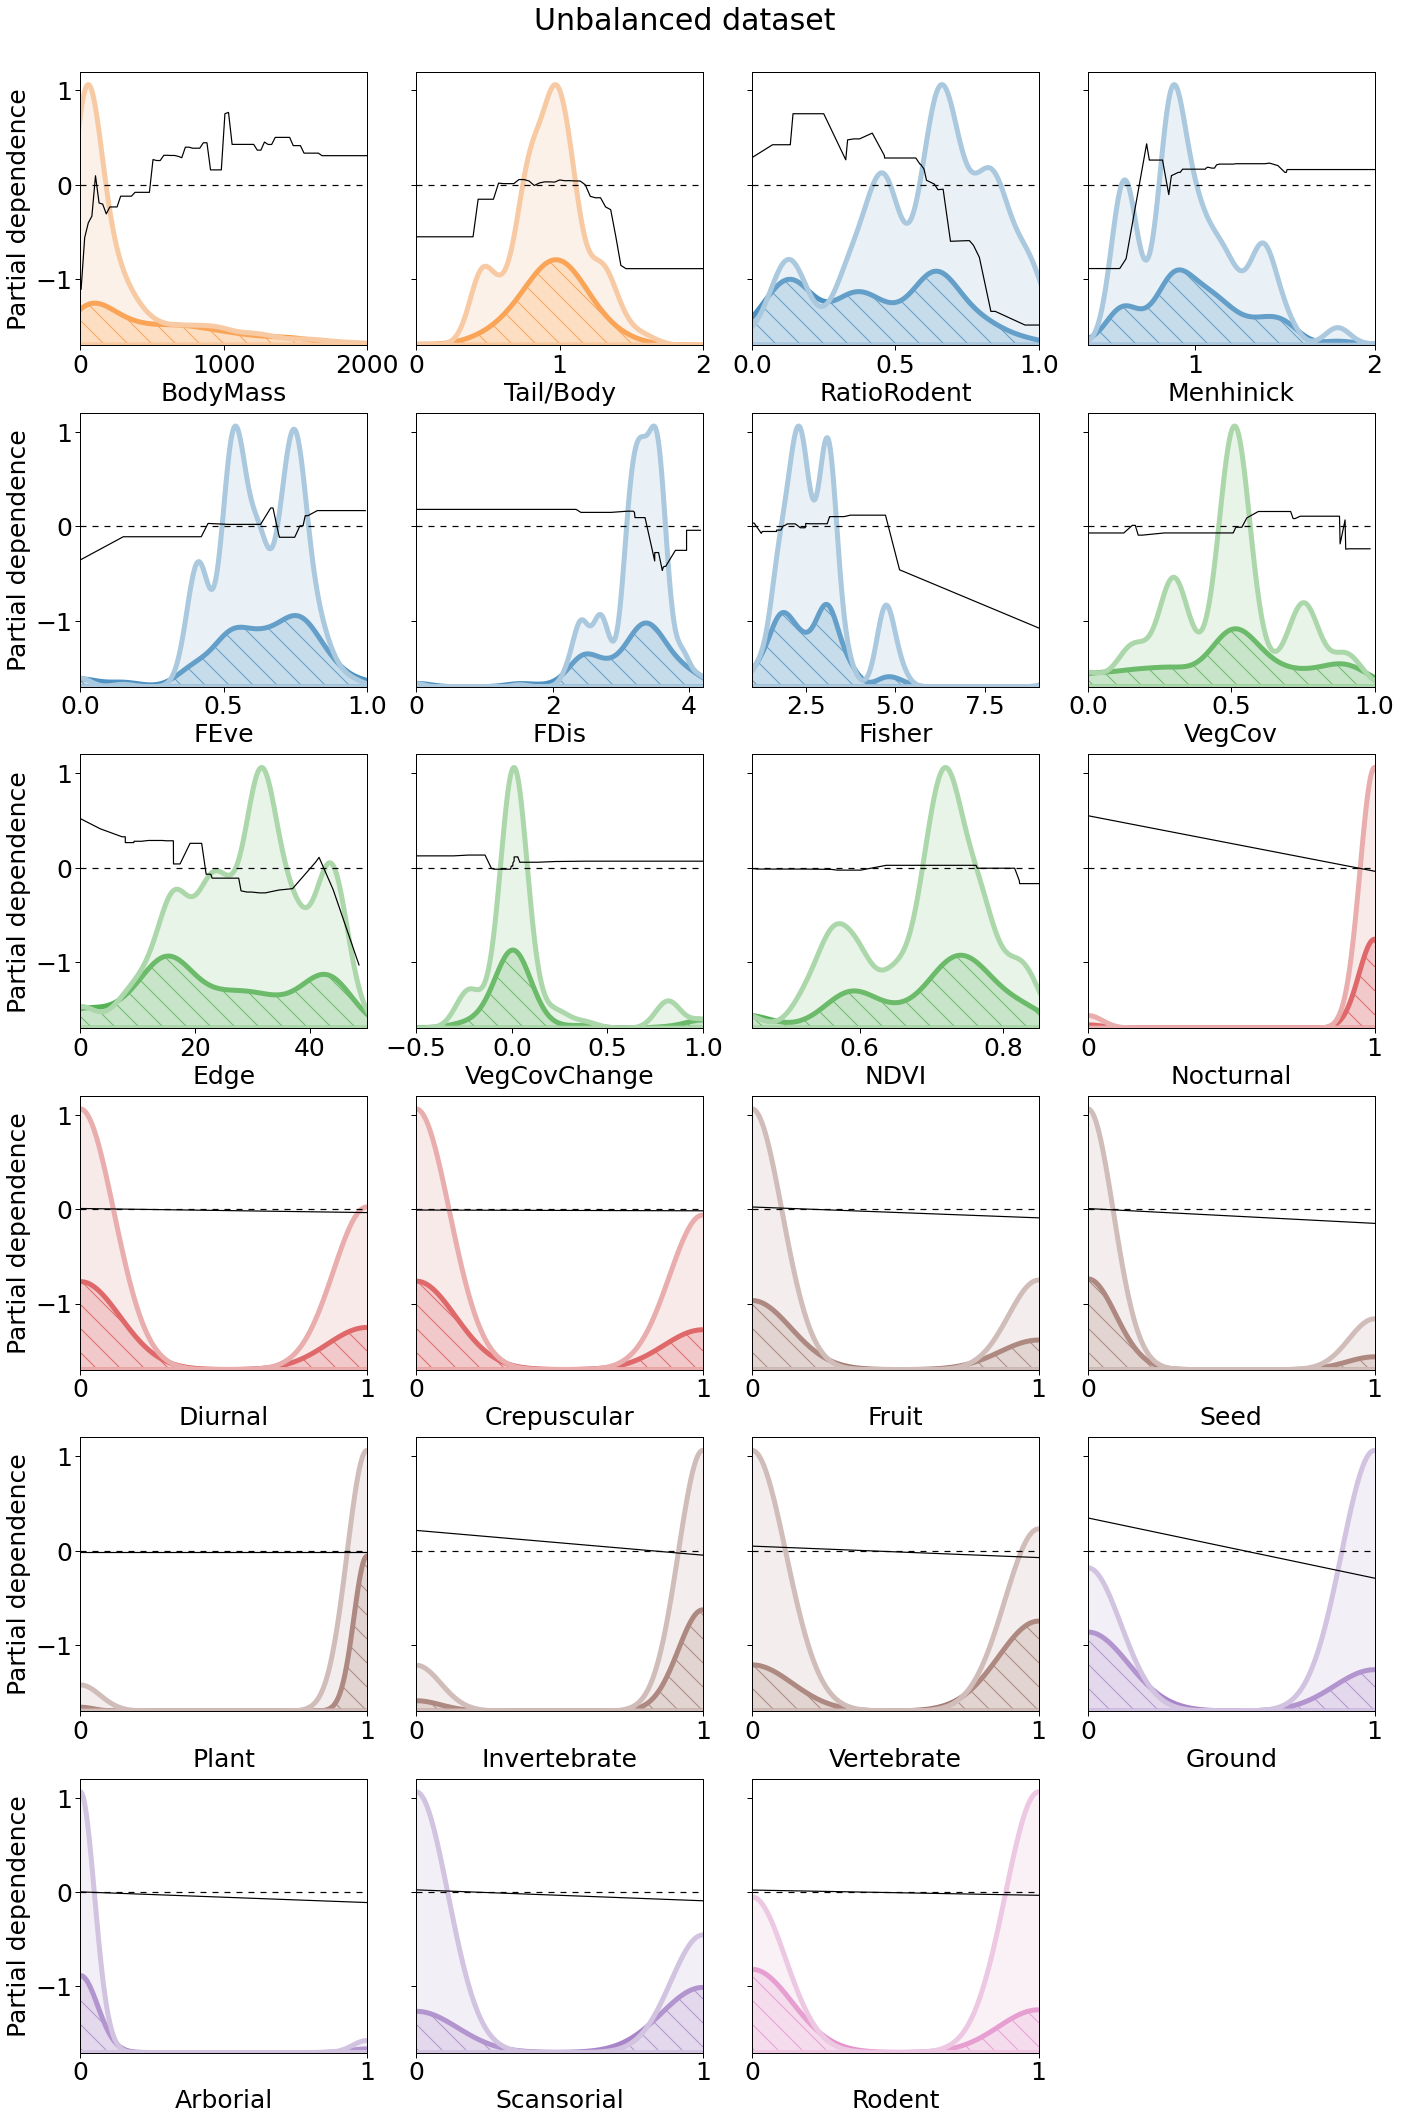

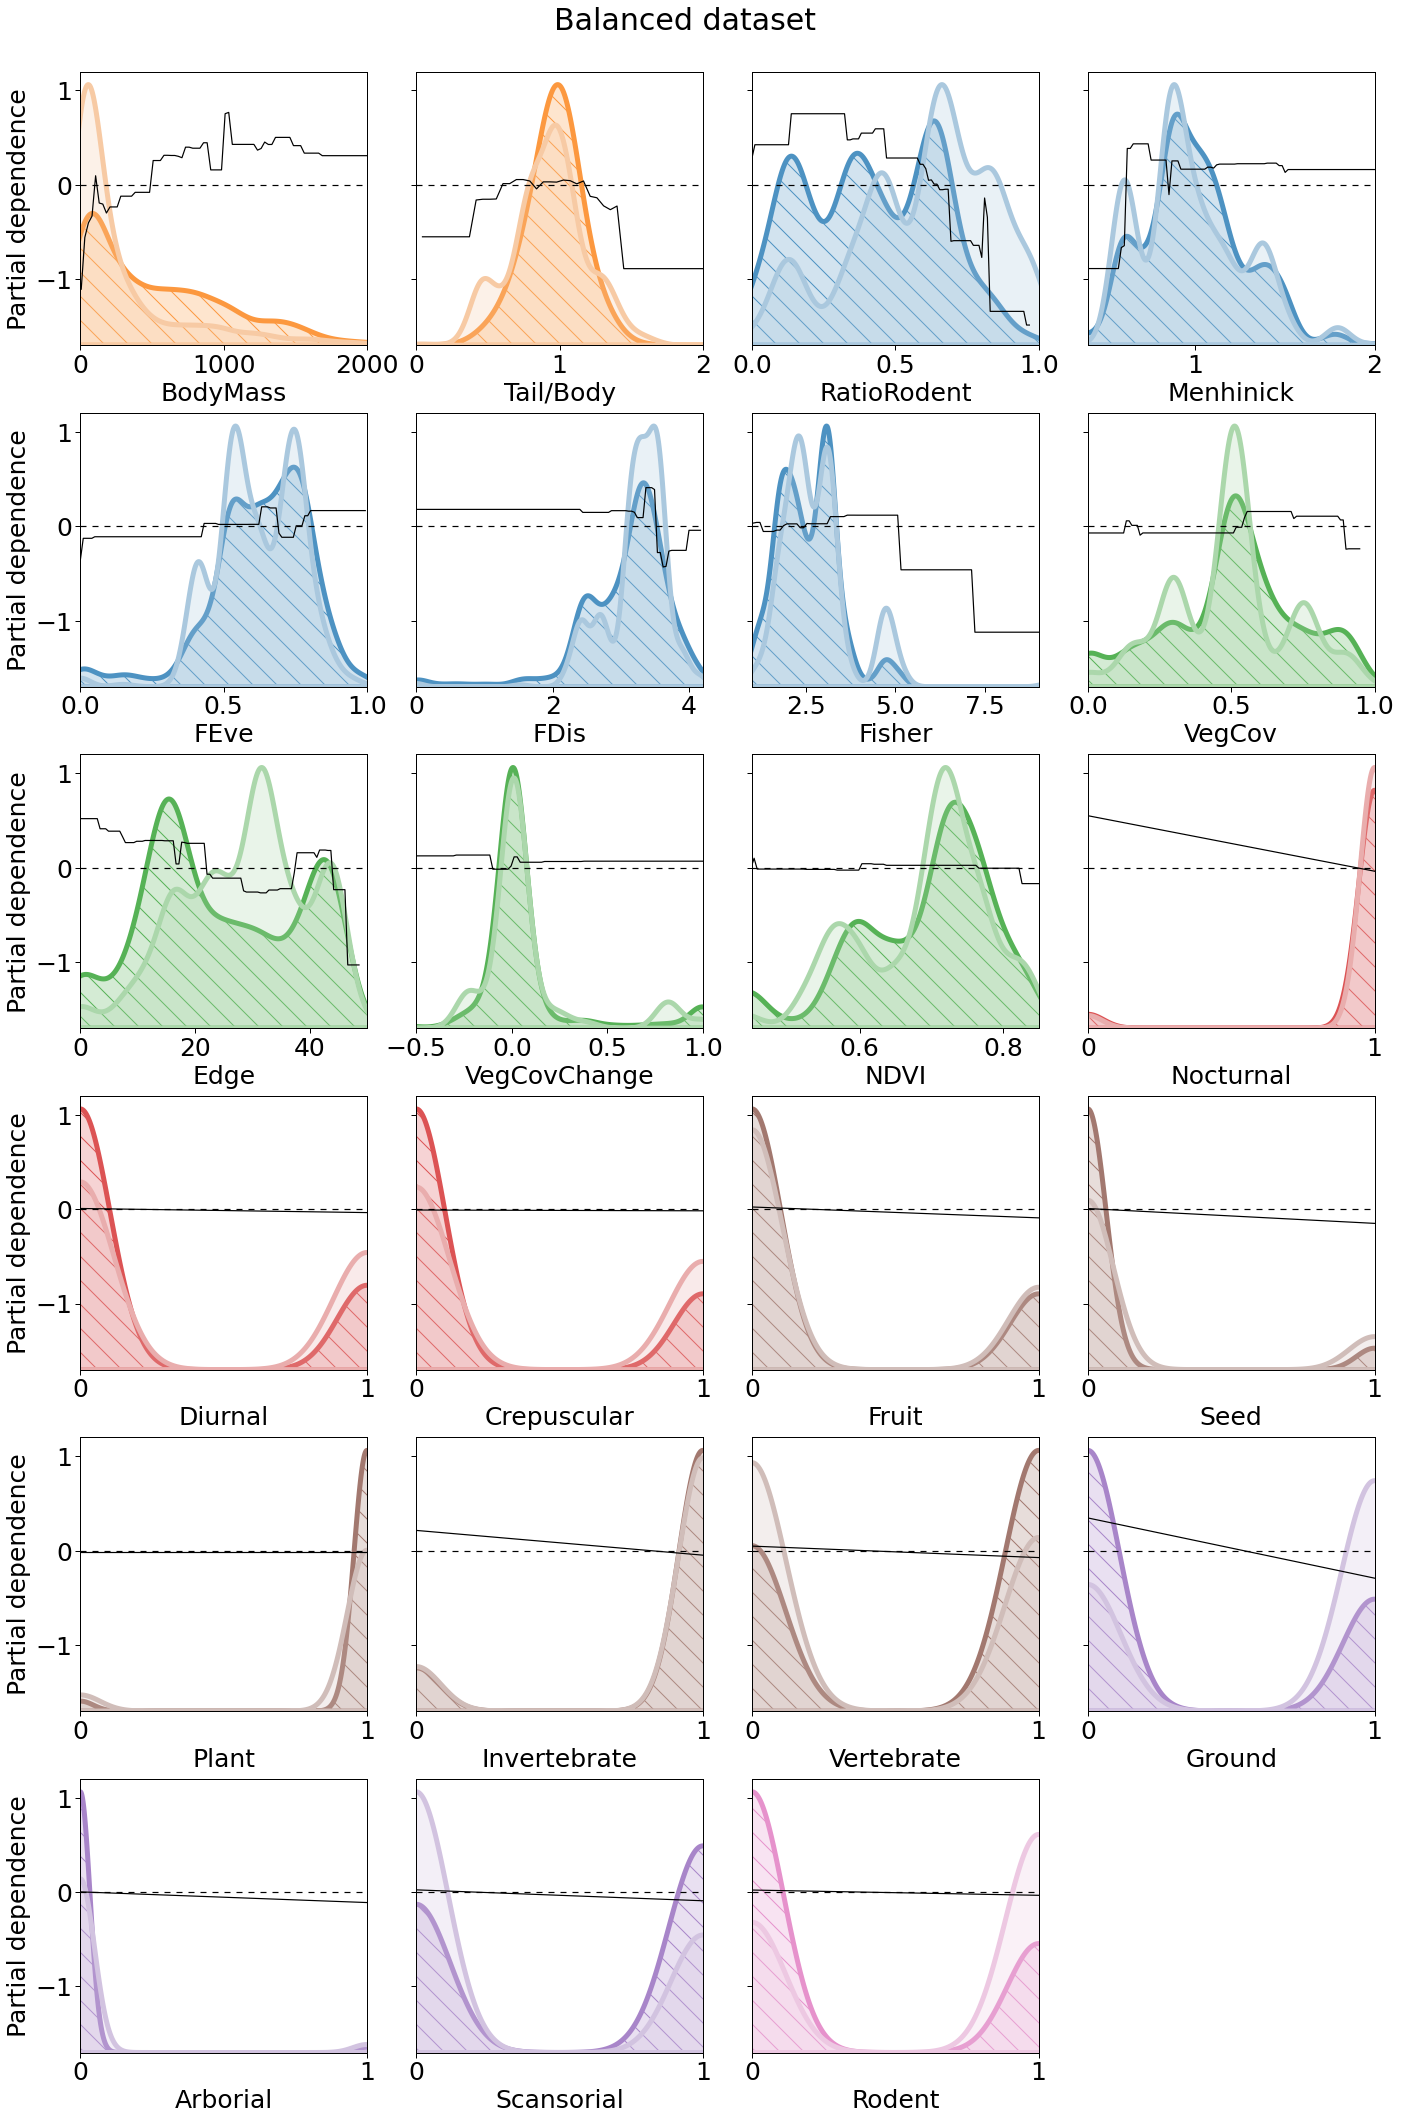

In [8]:
import matplotlib.patches as patches

model_type = GradientBoostingClassifier() 
col_PDP = ['BodyMass', 'Tail/Body', 'RatioRodent', 'Menhinick', 'FEve', 'FDis', 'Fisher', 'VegCov', 'Edge', 'VegCovChange', 'NDVI', 'Nocturnal', 'Diurnal', 'Crepuscular', 'Fruit', 'Seed', 'Plant', 'Invertebrate', 'Vertebrate', 'Ground', 'Arborial', 'Scansorial', 'Rodent','BodyMass' ] 
color = [pal[1], pal[1], pal[0],pal[0], pal[0], pal[0], pal[0], pal[2], pal[2], pal[2], pal[2], pal[3], pal[3], pal[3], pal[5], pal[5], pal[5], pal[5], pal[5], pal[4], pal[4], pal[4], pal[6], pal[7] ] #categories_col={'Biodiversity': pal[0], 'Morphology':pal[1], 'Land cover':pal[2], 'Activity':pal[3], 'Stratum':pal[4], 'Diet':pal[5], 'Taxonomy':pal[6]}

data_t_3 = data_ini.copy()[['infec'] + com_3 + env_3   + strat + activity + morfo + food]
data_t2_3 = data_t_3.copy()

y_3_unb = data_t_3['infec']
X_3_unb = data_t_3.drop(['infec'], axis=1)
X_3_unb.columns = X_3_unb.columns.to_series().map(dict_columns) 
data_t2_3.columns = data_t2_3.columns.to_series().map(dict_columns) 


#Xcategory_3_unb = X_3_unb.columns.to_series().map(dict_category)
model_3_unb = model_type
model_3_unb.fit(X_3_unb, y_3_unb)

X_3_bal, y_3_bal = SMOTE(random_state=1).fit_resample(X_3_unb, y_3_unb) # upsampling  
#Xcategory_3_bal = X_3_bal.columns.to_series().map(dict_category)
model_3_bal = model_type
model_3_bal.fit(X_3_bal, y_3_bal)
Xy_3_bal = X_3_bal.copy(); Xy_3_bal['Infected'] = y_3_bal

sns.set_context("paper", rc={"font.size":10,"axes.titlesize":25,"axes.labelsize":25}) 

f , ax = plt.subplots(ncols=4, nrows=6, figsize=(20, 30))
h = PartialDependenceDisplay.from_estimator(model_3_unb,X_3_unb,col_PDP, line_kw={"color": "white"}, ax=ax, percentiles=(0.001,0.999)); plt.setp(h.deciles_vlines_, visible=False)

ax3=np.copy(ax)
counter=-1
for ix,iy in np.ndindex(ax.shape):
    counter+=1
    ax1=ax[ix,iy]
    ax2=ax1.twinx()
    xlim = ax1.get_xlim()
    #ax[ix,iy].set(ylim=(0., 1.))
    #sns.histplot(data=X_3_unb, x=col_PDP[counter], stat='density', color=color[counter], bins=15, binrange=xlim, ax=ax2)
    palette=sns.set_palette((sns.light_palette(color[counter],10,reverse=False))[3::4])
    #palette = sns.set_palette(sns.color_palette([color1, color2]))
    h=sns.kdeplot(data=data_t2_3, x=col_PDP[counter],  hue="Infected", fill=True, gridsize=2000, palette=palette, ax=ax2, legend=False, linewidth=5) 
    lss=['-','-']
    fss=['\\','']
    for line, ls, fs in zip(h.collections, lss, fss):
        line.set_linestyle(ls)
        line.set_hatch(fs)
    #ax[ix,iy].legend(loc="upper right", frameon=True, fontsize=20)
    #h.legend()
    #handles, labels = ax2.get_legend_handles_labels()
    #handles, labels = ax[ix,iy].get_legend_handles_labels()
    #print(labels)
    #handles, labels = ax2.get_legend_handles_labels()
    #print(labels)
    #ax[ix,iy].legend(handles=handles[1:], labels=labels[1:], title="Whatever else")
    #h.legend()
    #new_labels = ['No', 'Yes']
    #for t, l in zip(ax[ix,iy]._legend.texts, new_labels): t.set_text(l)
    ax2.get_yaxis().set_visible(False)
    ax1.set(xlim=xlim)
    ax1.tick_params(axis='y', which='major', labelsize=25)
    ax1.tick_params(axis='x', which='major', labelsize=25)
    ax3[ix,iy]=ax2.twinx()
    ax3[ix,iy].get_yaxis().set_visible(False)
    ax3[ix,iy].axhline(0, ls='--', dashes=(5,5), c='black')
h = PartialDependenceDisplay.from_estimator(model_3_unb,X_3_unb,col_PDP, line_kw={"color": "black"}, ax=ax3, percentiles=(0.001,0.999)); plt.setp(h.deciles_vlines_, visible=False)

for ii in np.arange(6):
    for jj in np.arange(4):
        ax3[ii,jj].set(ylim=[-1.7,1.2])
        ax[ii,jj].set(ylim=[-1.7,1.2])
ax[0,0].set(xlim=[0,2000])
ax[0,1].set(xlim=[0,2])
ax[0,2].set(xlim=[0,1])
ax[0,3].set(xlim=[0.4,2])
ax[1,0].set(xlim=[0,1])
ax[1,1].set(xlim=[0,4.2])
ax[1,2].set(xlim=[1,9]) # Fisher
ax[1,3].set(xlim=[0,1])
ax[2,0].set(xlim=[0,50]) # MODIFICADO: Nuevo Edge
ax[2,1].set(xlim=[-0.5,1])
ax[2,2].set(xlim=[0.45,0.85]) # NDVI
ax[2,3].set(xlim=[0,1])
ax[2,3].xaxis.set_ticks([0,1])
for ii in [3,4,5]:
    for jj in [0,1,2,3]:
        ax[ii,jj].set(xlim=[0,1])
        ax[ii,jj].xaxis.set_ticks([0,1])
ax3[-1,-1].clear()
ax3[-1,-1].remove()
ax[-1,-1].remove()
ax2.remove()


f.tight_layout()
f.suptitle('Unbalanced dataset', fontsize=30)
f.subplots_adjust(top=0.95,left=0.08)
f.savefig('PDP_3_ALL_unb.svg')
f.savefig('PDP_3_ALL_unb.jpg')
f.savefig('PDP_3_ALL_unb.pdf')

f , ax = plt.subplots(ncols=4, nrows=6, figsize=(20, 30))
h = PartialDependenceDisplay.from_estimator(model_3_unb,X_3_bal,col_PDP, line_kw={"color": "white"}, ax=ax, percentiles=(0.001,0.999)); plt.setp(h.deciles_vlines_, visible=False)
ax3=np.copy(ax)
counter=-1
for ix,iy in np.ndindex(ax.shape):
    counter+=1
    ax1=ax[ix,iy]
    ax2=ax1.twinx()
    xlim = ax1.get_xlim()
    #ax[ix,iy].set(ylim=(0., 1.))
    palette=sns.set_palette((sns.light_palette(color[counter],10,reverse=False))[3::4])
    #palette = sns.set_palette(sns.color_palette([color1, color2]))
    h=sns.kdeplot(data=Xy_3_bal, x=col_PDP[counter], hue="Infected", fill=True, gridsize=2000, palette=palette, ax=ax2, legend=False, linewidth=5) 
    lss=['-','-']
    fss=['\\','']
    for line, ls, fs in zip(h.collections, lss, fss):
        line.set_linestyle(ls)
        line.set_hatch(fs)
    ax2.get_yaxis().set_visible(False)
    ax1.set(xlim=xlim)
    ax1.tick_params(axis='y', which='major', labelsize=25)
    ax1.tick_params(axis='x', which='major', labelsize=25)
    ax3[ix,iy]=ax2.twinx()
    ax3[ix,iy].get_yaxis().set_visible(False)
    ax3[ix,iy].axhline(0, ls='--', dashes=(5,5), c='black')
h = PartialDependenceDisplay.from_estimator(model_3_bal,X_3_bal,col_PDP, line_kw={"color": "black"}, ax=ax3, percentiles=(0.001,0.999)); plt.setp(h.deciles_vlines_, visible=False)

for ii in np.arange(6):
    for jj in np.arange(4):
        ax3[ii,jj].set(ylim=[-1.7,1.2])
        ax[ii,jj].set(ylim=[-1.7,1.2])
ax[0,0].set(xlim=[0,2000])
ax[0,1].set(xlim=[0,2])
ax[0,2].set(xlim=[0,1])
ax[0,3].set(xlim=[0.4,2])
ax[1,0].set(xlim=[0,1])
ax[1,1].set(xlim=[0,4.2])
ax[1,2].set(xlim=[1,9]) # Fisher
ax[1,3].set(xlim=[0,1])
ax[2,0].set(xlim=[0,50]) # MODIFICADO: Nuevo Edge
ax[2,1].set(xlim=[-0.5,1])
ax[2,2].set(xlim=[0.45,0.85]) # NDVI
ax[2,3].set(xlim=[0,1])
ax[2,3].xaxis.set_ticks([0,1])
for ii in [3,4,5]:
    for jj in [0,1,2,3]:
        ax[ii,jj].set(xlim=[0,1])
        ax[ii,jj].xaxis.set_ticks([0,1])
ax3[-1,-1].clear()
ax3[-1,-1].remove()
ax[-1,-1].remove()
ax2.remove()


f.tight_layout()
f.suptitle('Balanced dataset', fontsize=30)
f.subplots_adjust(top=0.95,left=0.08)
f.savefig('PDP_3_ALL_bal.svg')
f.savefig('PDP_3_ALL_bal.jpg')
f.savefig('PDP_3_ALL_bal.pdf')

/home/abraxas/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/tmp/ipykernel_16617/3148924238.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_importance[cats_importance<0]=0  # just in case
/home/abraxas/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/tmp/ipykernel_16617/

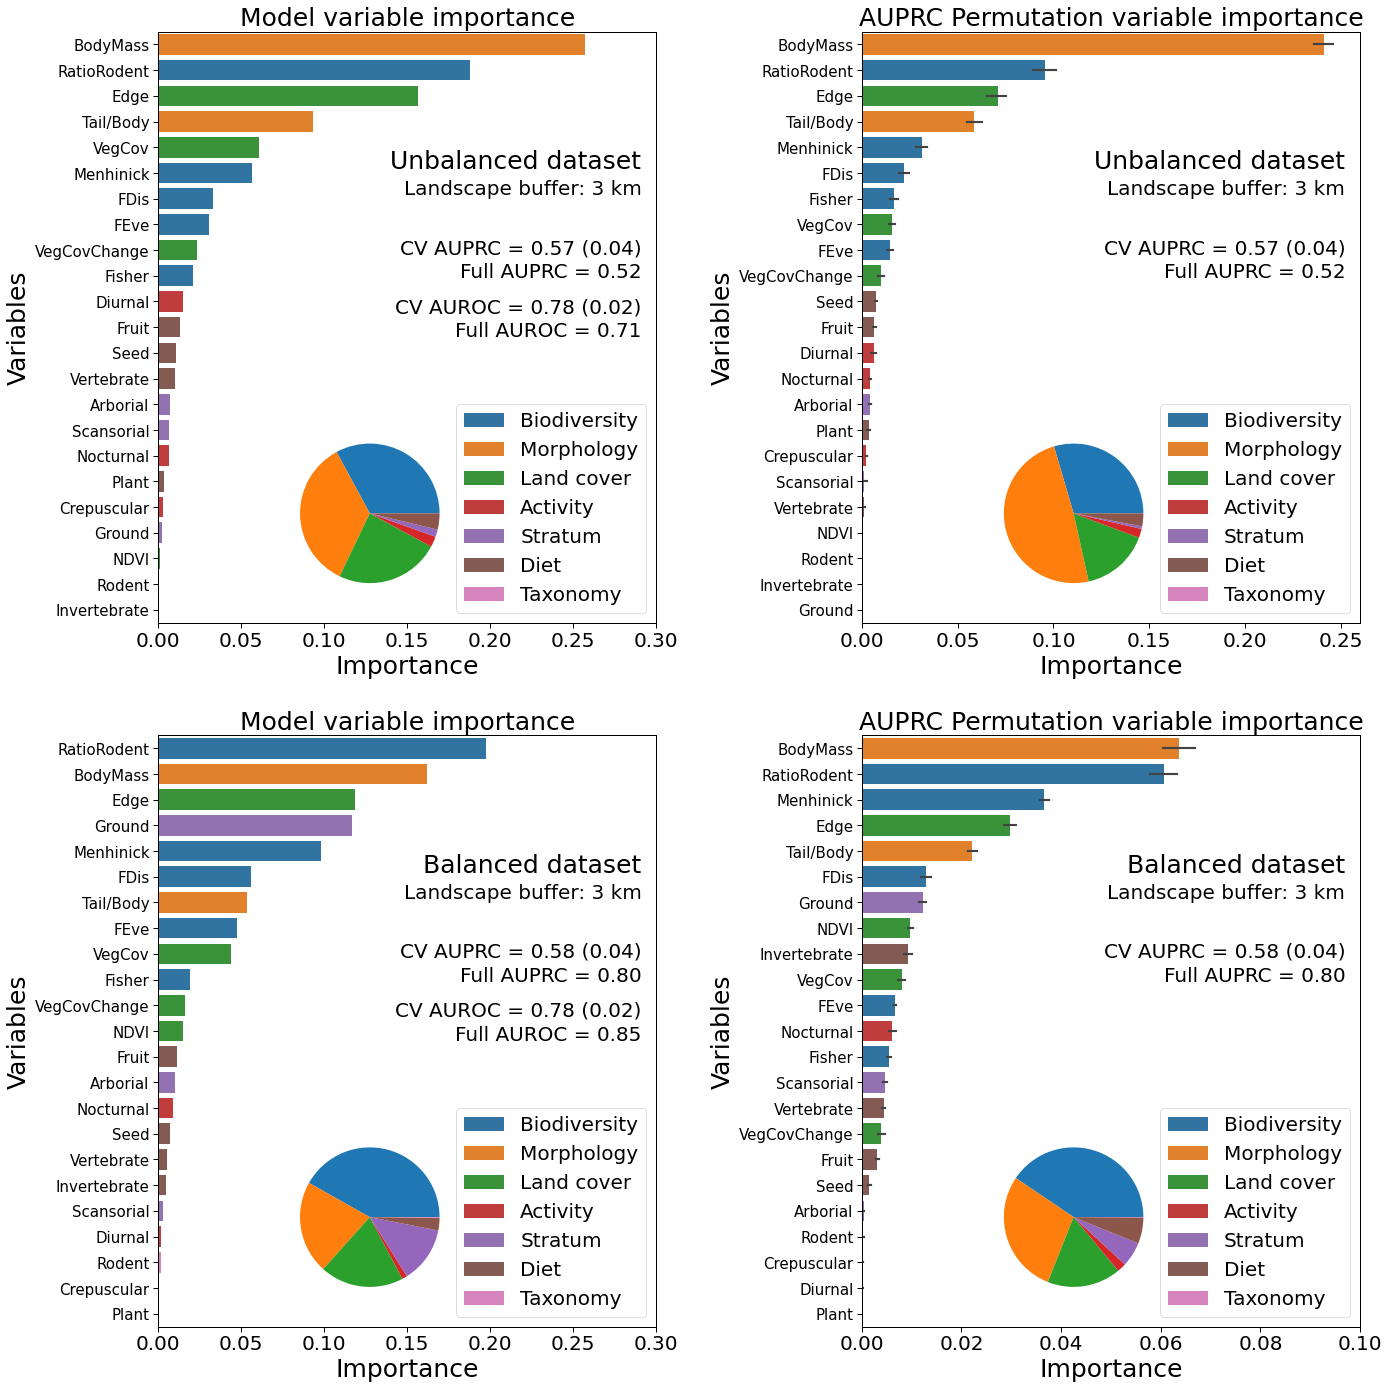

In [4]:
name='feature_importance_3km_selec'
sns.set_context("paper", rc={"font.size":30,"axes.titlesize":25,"axes.labelsize":25})     
fig, axes = plt.subplots(2,2 , figsize=(20,20))

ax=axes[0][0]; var_imp_plot(Xnames, model_imp_3_unb, Xcategory, 'Model variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.30))
ax.text(0.97, 0.8, "Unbalanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 3 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.55, "CV AUROC = " + str(round(ROC_CV_3_unb.mean(),2)) + ' (' + str(round(ROC_CV_3_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.51, "Full AUROC = " + str(round(ROCmodel_3_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_3_unb.mean(),2)) + ' (' + str(round(AP_CV_3_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + str(round(APmodel_3_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
#ax.text(0.97, 0.45, "CV MCC = " + str(round(MCC_CV_3_unb.mean(),2)) + ' (' + str(round(MCC_CV_3_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
#ax.text(0.97, 0.41, "MCC = " + str(round(MCCmodel_3_unb,3)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[0][1]; var_imp_plot(Xnames, permut_imp_AP_3_unb.importances, Xcategory, 'AUPRC Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.26))
ax.text(0.97, 0.8, "Unbalanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 3 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_3_unb.mean(),2)) + ' (' + str(round(AP_CV_3_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + str(round(APmodel_3_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)

ax=axes[1][0]; var_imp_plot(Xnames, model_imp_3_bal, Xcategory, 'Model variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.30))
ax.text(0.97, 0.8, "Balanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 3 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
#ax.text(0.97, 0.55, "CV AUROC = " + str(round(ROC_CV_3_bal.mean(),2)) + ' (' + str(round(ROC_CV_3_bal.std(),2)) + ')' + '  ' + str(round(ROC_CV_3_bal_B.mean(),2)) + ' (' + str(round(ROC_CV_3_bal_B.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.55, "CV AUROC = " + str(round(ROC_CV_3_bal.mean(),2)) + ' (' + str(round(ROC_CV_3_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.51, "Full AUROC = " + str(round(ROCmodel_3_bal,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
#ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_3_bal.mean(),2)) + ' (' + str(round(AP_CV_3_bal.std(),2)) + ')' + '  ' + str(round(AP_CV_3_bal_B.mean(),2)) + ' (' + str(round(AP_CV_3_bal_B.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_3_bal.mean(),2)) + ' (' + str(round(AP_CV_3_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + f"{APmodel_3_bal:.2f}", ha="right", va="top", transform=ax.transAxes, fontsize=20)
#ax.text(0.97, 0.45, "CV MCC = " + str(round(MCC_CV_3_bal.mean(),2)) + ' (' + str(round(MCC_CV_3_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
#ax.text(0.97, 0.41, "MCC = " + str(round(MCCmodel_3_bal,3)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[1][1]; var_imp_plot(Xnames, permut_imp_AP_3_bal.importances, Xcategory, 'AUPRC Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.1))
ax.text(0.97, 0.8, "Balanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 3 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_3_bal.mean(),2)) + ' (' + str(round(AP_CV_3_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + f"{APmodel_3_bal:.2f}", ha="right", va="top", transform=ax.transAxes, fontsize=20)

fig.tight_layout()

fig.savefig(name + '.svg')
fig.savefig(name + '.jpg')
fig.savefig(name + '.pdf')

/home/abraxas/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/tmp/ipykernel_16617/3148924238.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_importance[cats_importance<0]=0  # just in case
/home/abraxas/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/tmp/ipykernel_16617/

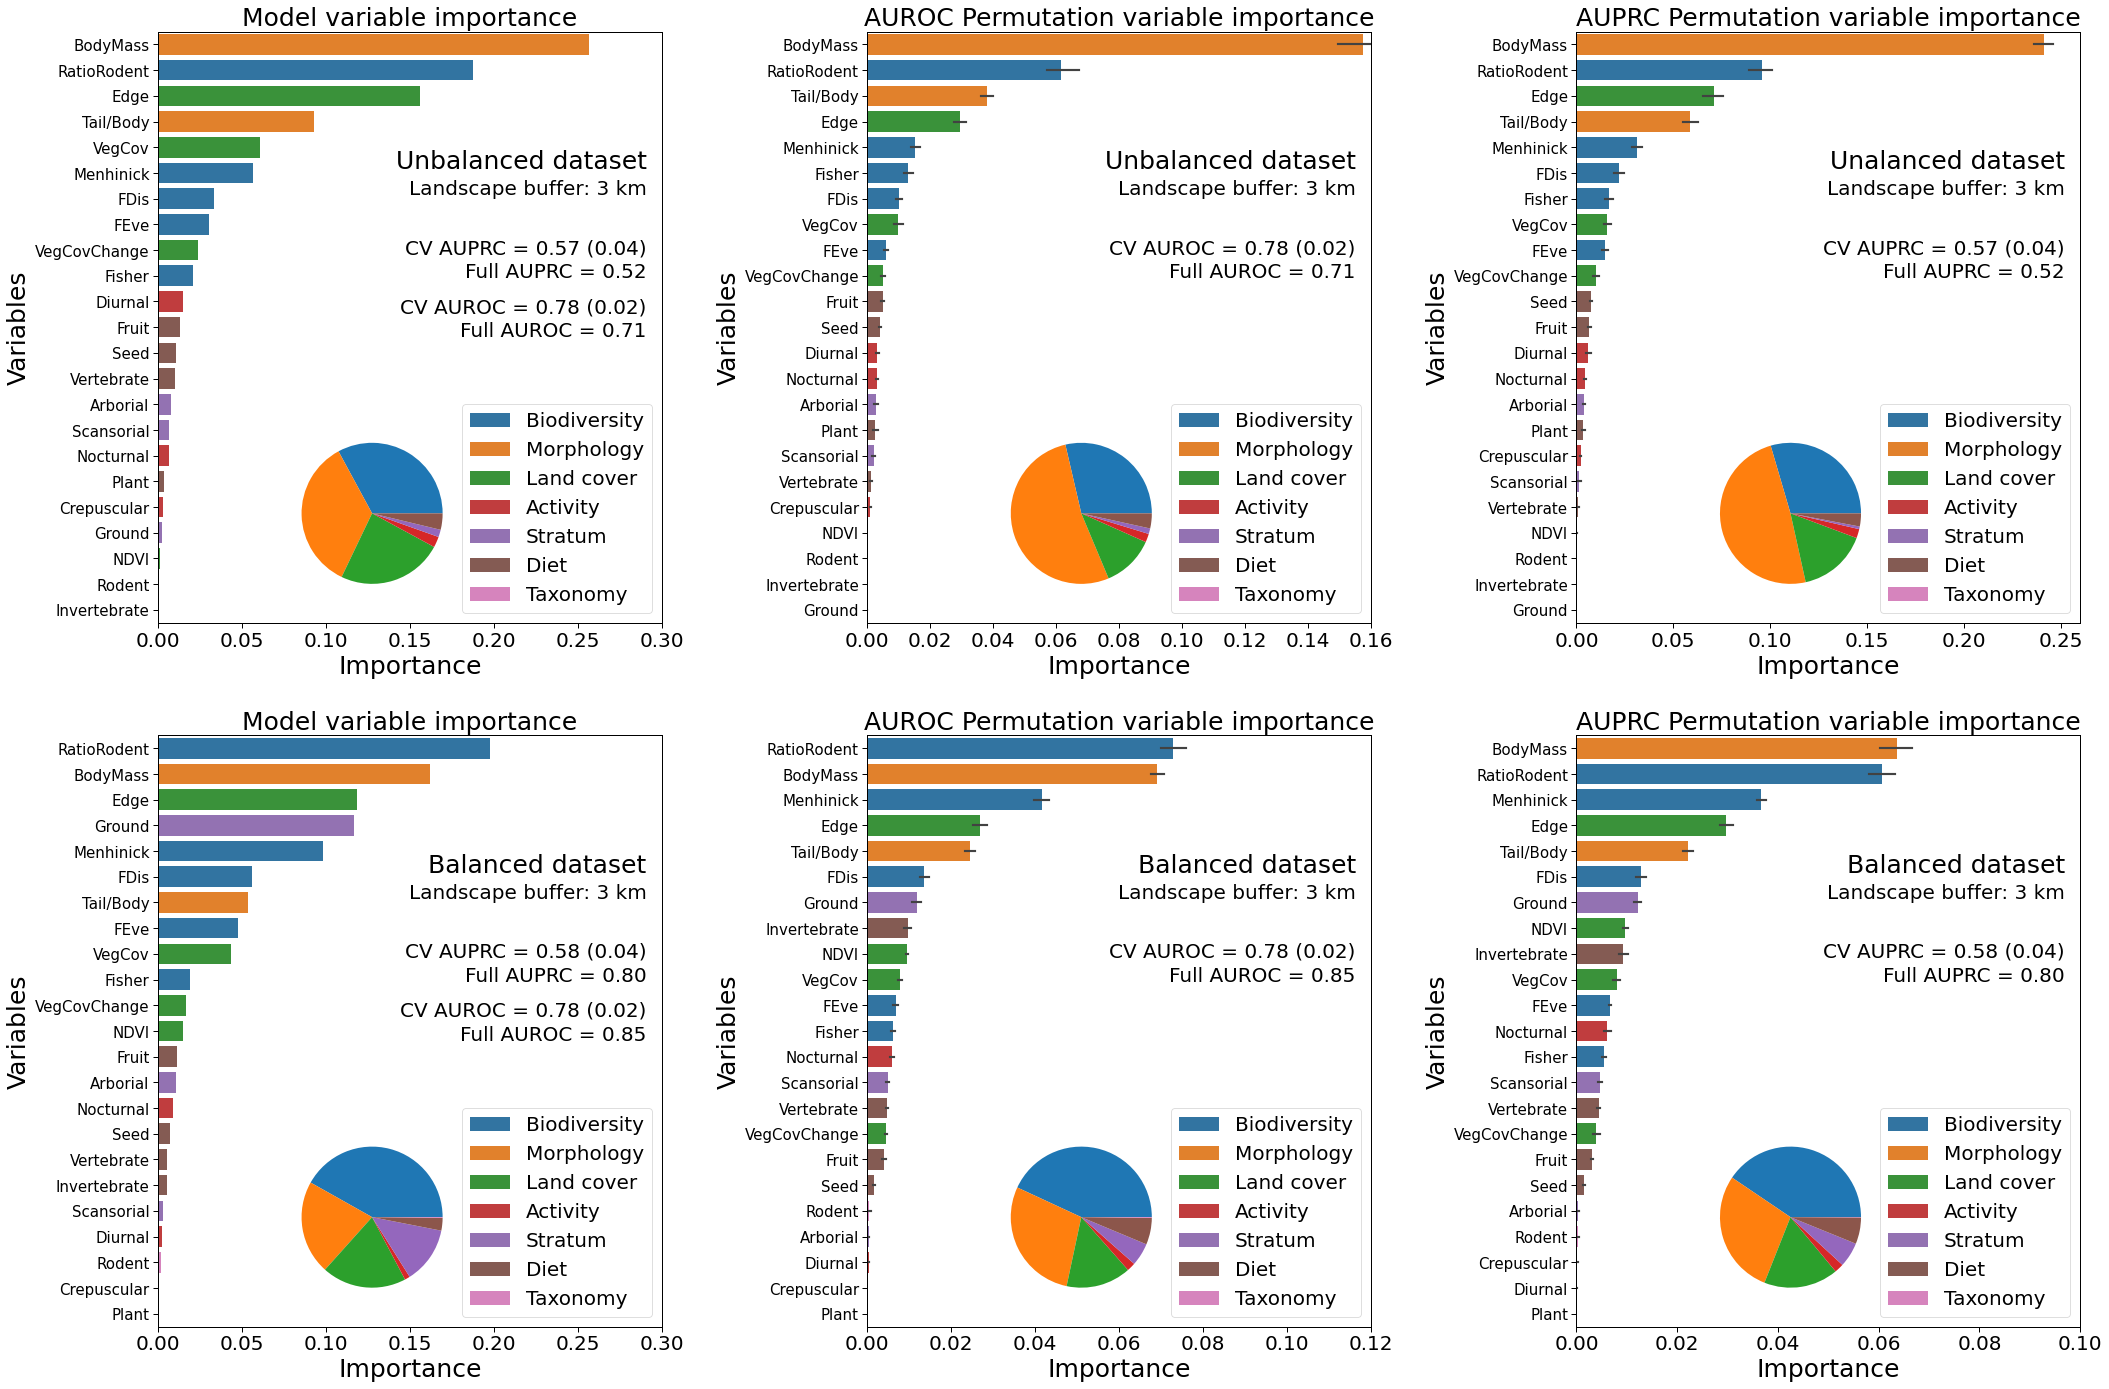

In [5]:
name='feature_importance_3km'
sns.set_context("paper", rc={"font.size":30,"axes.titlesize":25,"axes.labelsize":25})     
fig, axes = plt.subplots(2,3 , figsize=(30,20))

ax=axes[0][0]; var_imp_plot(Xnames, model_imp_3_unb, Xcategory, 'Model variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.30))
ax.text(0.97, 0.8, "Unbalanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 3 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.55, "CV AUROC = " + str(round(ROC_CV_3_unb.mean(),2)) + ' (' + str(round(ROC_CV_3_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.51, "Full AUROC = " + str(round(ROCmodel_3_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_3_unb.mean(),2)) + ' (' + str(round(AP_CV_3_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + str(round(APmodel_3_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
#ax.text(0.97, 0.45, "CV MCC = " + str(round(MCC_CV_3_unb.mean(),2)) + ' (' + str(round(MCC_CV_3_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
#ax.text(0.97, 0.41, "MCC = " + str(round(MCCmodel_3_unb,3)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[0][1]; var_imp_plot(Xnames, permut_imp_ROC_3_unb.importances, Xcategory, 'AUROC Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.16))
ax.text(0.97, 0.8, "Unbalanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 3 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUROC = " + str(round(ROC_CV_3_unb.mean(),2)) + ' (' + str(round(ROC_CV_3_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUROC = " + str(round(ROCmodel_3_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[0][2]; var_imp_plot(Xnames, permut_imp_AP_3_unb.importances, Xcategory, 'AUPRC Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.26))
ax.text(0.97, 0.8, "Unalanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 3 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_3_unb.mean(),2)) + ' (' + str(round(AP_CV_3_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + str(round(APmodel_3_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)

ax=axes[1][0]; var_imp_plot(Xnames, model_imp_3_bal, Xcategory, 'Model variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.30))
ax.text(0.97, 0.8, "Balanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 3 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
#ax.text(0.97, 0.55, "CV AUROC = " + str(round(ROC_CV_3_bal.mean(),2)) + ' (' + str(round(ROC_CV_3_bal.std(),2)) + ')' + '  ' + str(round(ROC_CV_3_bal_B.mean(),2)) + ' (' + str(round(ROC_CV_3_bal_B.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.55, "CV AUROC = " + str(round(ROC_CV_3_bal.mean(),2)) + ' (' + str(round(ROC_CV_3_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.51, "Full AUROC = " + str(round(ROCmodel_3_bal,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
#ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_3_bal.mean(),2)) + ' (' + str(round(AP_CV_3_bal.std(),2)) + ')' + '  ' + str(round(AP_CV_3_bal_B.mean(),2)) + ' (' + str(round(AP_CV_3_bal_B.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_3_bal.mean(),2)) + ' (' + str(round(AP_CV_3_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + f"{APmodel_3_bal:.2f}", ha="right", va="top", transform=ax.transAxes, fontsize=20)
#ax.text(0.97, 0.45, "CV MCC = " + str(round(MCC_CV_3_bal.mean(),2)) + ' (' + str(round(MCC_CV_3_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
#ax.text(0.97, 0.41, "MCC = " + str(round(MCCmodel_3_bal,3)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[1][1]; var_imp_plot(Xnames, permut_imp_ROC_3_bal.importances, Xcategory, 'AUROC Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.12))
ax.text(0.97, 0.8, "Balanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 3 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUROC = " + str(round(ROC_CV_3_bal.mean(),2)) + ' (' + str(round(ROC_CV_3_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUROC = " + str(round(ROCmodel_3_bal,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[1][2]; var_imp_plot(Xnames, permut_imp_AP_3_bal.importances, Xcategory, 'AUPRC Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.1))
ax.text(0.97, 0.8, "Balanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 3 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_3_bal.mean(),2)) + ' (' + str(round(AP_CV_3_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + f"{APmodel_3_bal:.2f}", ha="right", va="top", transform=ax.transAxes, fontsize=20)

fig.tight_layout()

fig.savefig(name + '.svg')
fig.savefig(name + '.jpg')
fig.savefig(name + '.pdf')

/home/abraxas/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/tmp/ipykernel_16617/3148924238.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_importance[cats_importance<0]=0  # just in case
/home/abraxas/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/tmp/ipykernel_16617/

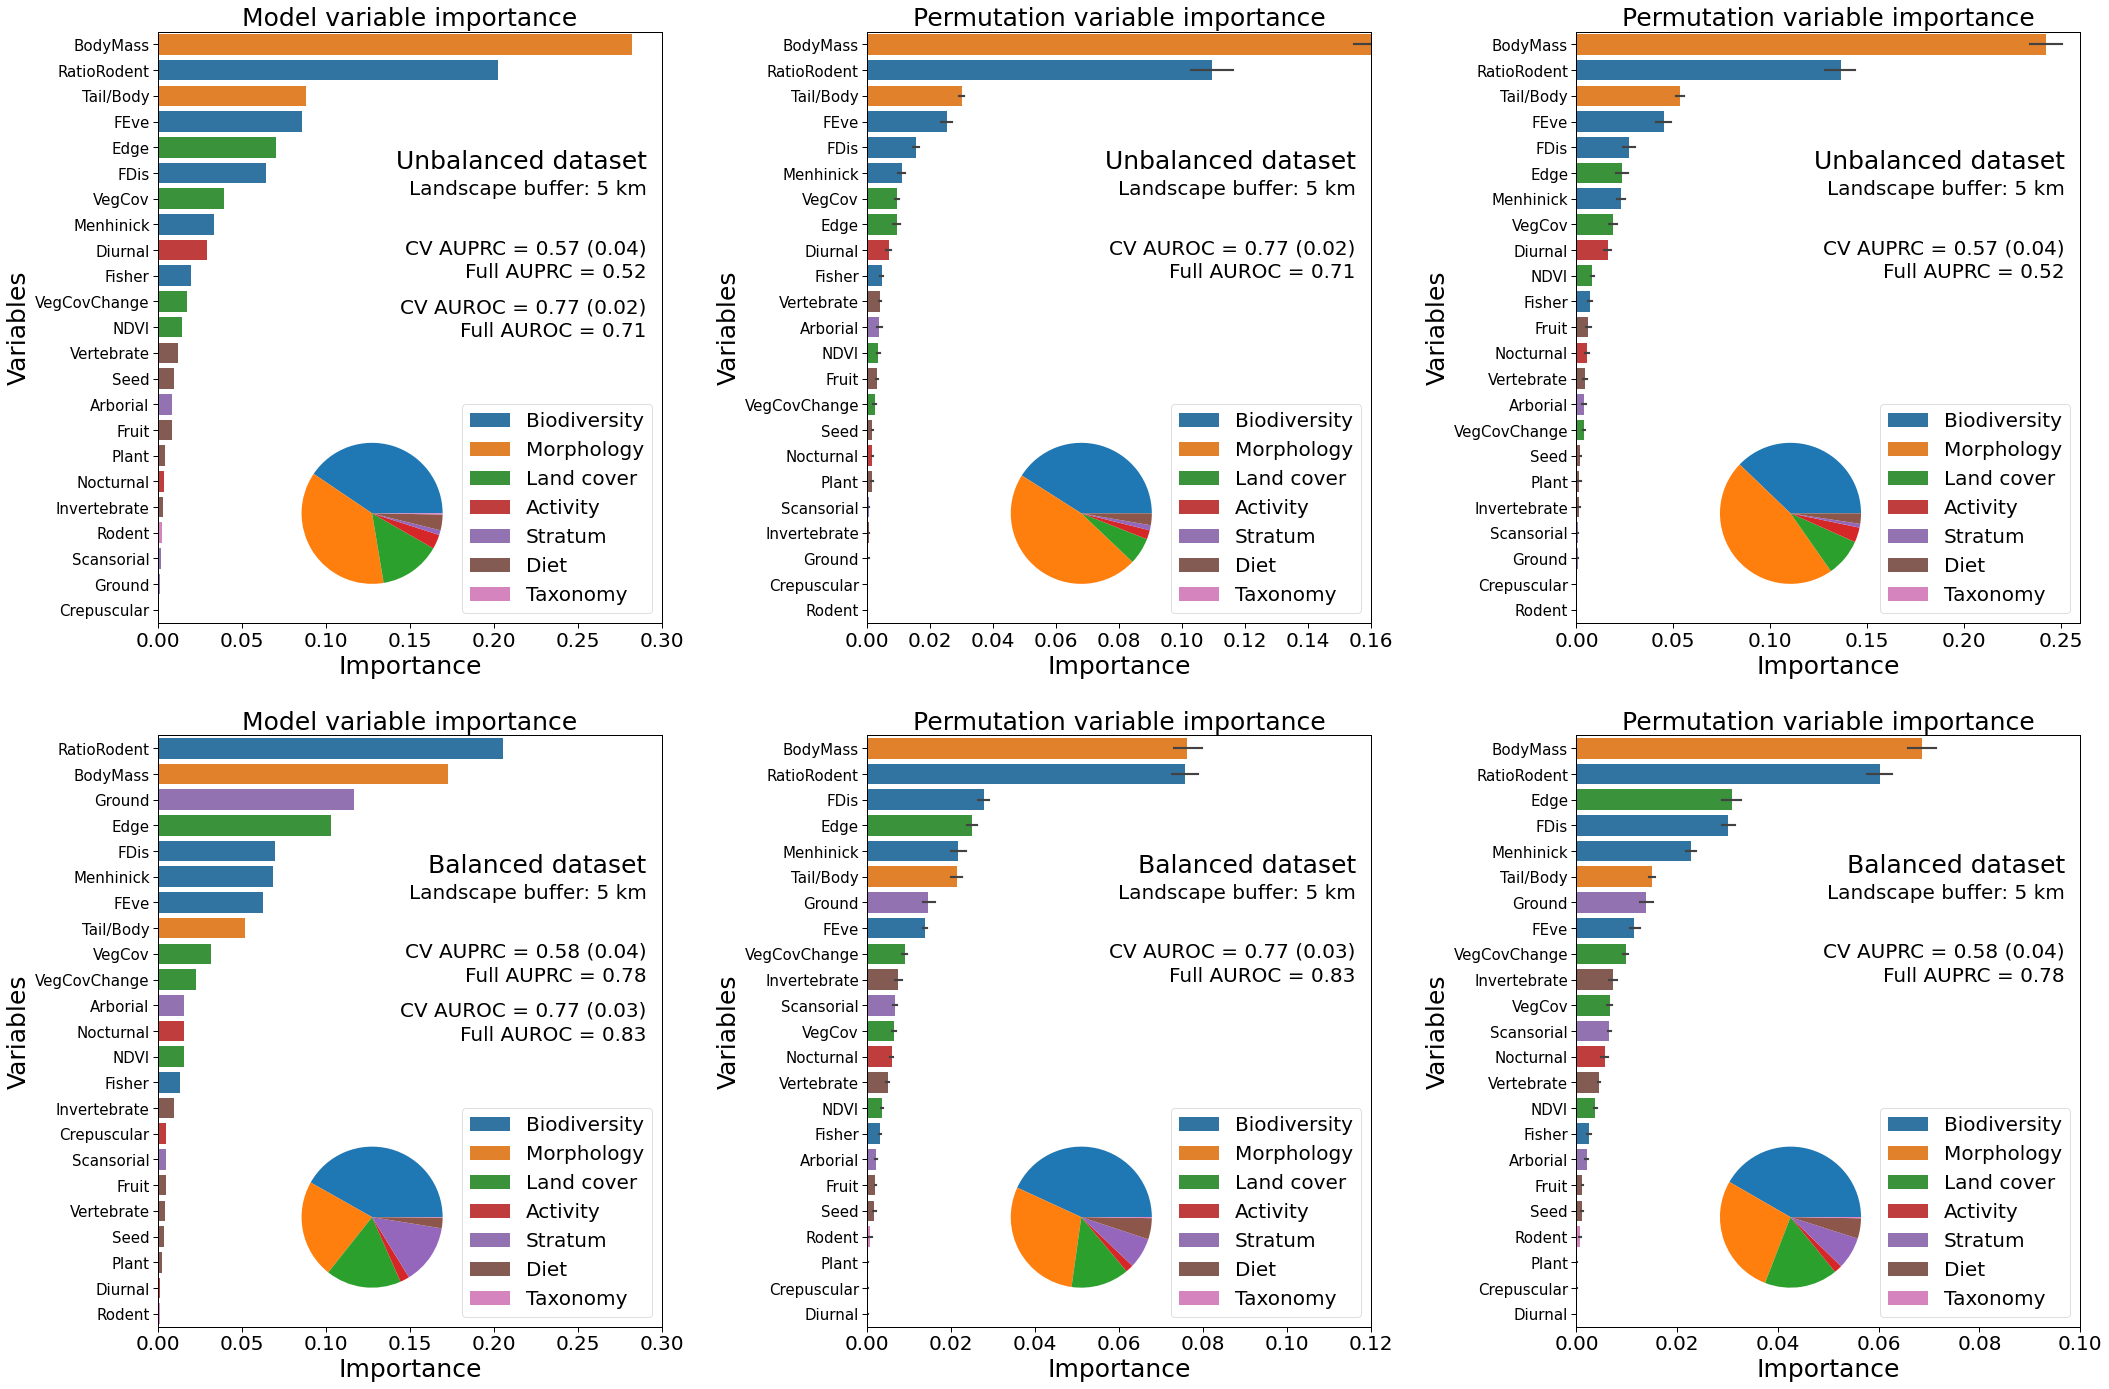

In [6]:
name='feature_importance_5km'
sns.set_context("paper", rc={"font.size":30,"axes.titlesize":25,"axes.labelsize":25})     
fig, axes = plt.subplots(2,3 , figsize=(30,20))

ax=axes[0][0]; var_imp_plot(Xnames, model_imp_5_unb, Xcategory, 'Model variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.30))
ax.text(0.97, 0.8, "Unbalanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 5 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.55, "CV AUROC = " + str(round(ROC_CV_5_unb.mean(),2)) + ' (' + str(round(ROC_CV_5_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.51, "Full AUROC = " + str(round(ROCmodel_5_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_5_unb.mean(),2)) + ' (' + str(round(AP_CV_5_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + str(round(APmodel_5_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[0][1]; var_imp_plot(Xnames, permut_imp_ROC_5_unb.importances, Xcategory, 'Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.16))
ax.text(0.97, 0.8, "Unbalanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 5 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUROC = " + str(round(ROC_CV_5_unb.mean(),2)) + ' (' + str(round(ROC_CV_5_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUROC = " + str(round(ROCmodel_5_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[0][2]; var_imp_plot(Xnames, permut_imp_AP_5_unb.importances, Xcategory, 'Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.26))
ax.text(0.97, 0.8, "Unbalanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 5 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_5_unb.mean(),2)) + ' (' + str(round(AP_CV_5_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + str(round(APmodel_5_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)

ax=axes[1][0]; var_imp_plot(Xnames, model_imp_5_bal, Xcategory, 'Model variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.30))
ax.text(0.97, 0.8, "Balanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 5 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.55, "CV AUROC = " + str(round(ROC_CV_5_bal.mean(),2)) + ' (' + str(round(ROC_CV_5_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.51, "Full AUROC = " + str(round(ROCmodel_5_bal,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_5_bal.mean(),2)) + ' (' + str(round(AP_CV_5_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + f"{APmodel_5_bal:.2f}", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[1][1]; var_imp_plot(Xnames, permut_imp_ROC_5_bal.importances, Xcategory, 'Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.12))
ax.text(0.97, 0.8, "Balanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 5 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUROC = " + str(round(ROC_CV_5_bal.mean(),2)) + ' (' + str(round(ROC_CV_5_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUROC = " + str(round(ROCmodel_5_bal,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[1][2]; var_imp_plot(Xnames, permut_imp_AP_5_bal.importances, Xcategory, 'Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.1))
ax.text(0.97, 0.8, "Balanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 5 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_5_bal.mean(),2)) + ' (' + str(round(AP_CV_5_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + f"{APmodel_5_bal:.2f}", ha="right", va="top", transform=ax.transAxes, fontsize=20)

fig.tight_layout()

fig.savefig(name + '.jpg')
fig.savefig(name + '.svg')
fig.savefig(name + '.pdf')

/home/abraxas/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/tmp/ipykernel_16617/3148924238.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_importance[cats_importance<0]=0  # just in case
/home/abraxas/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/tmp/ipykernel_16617/

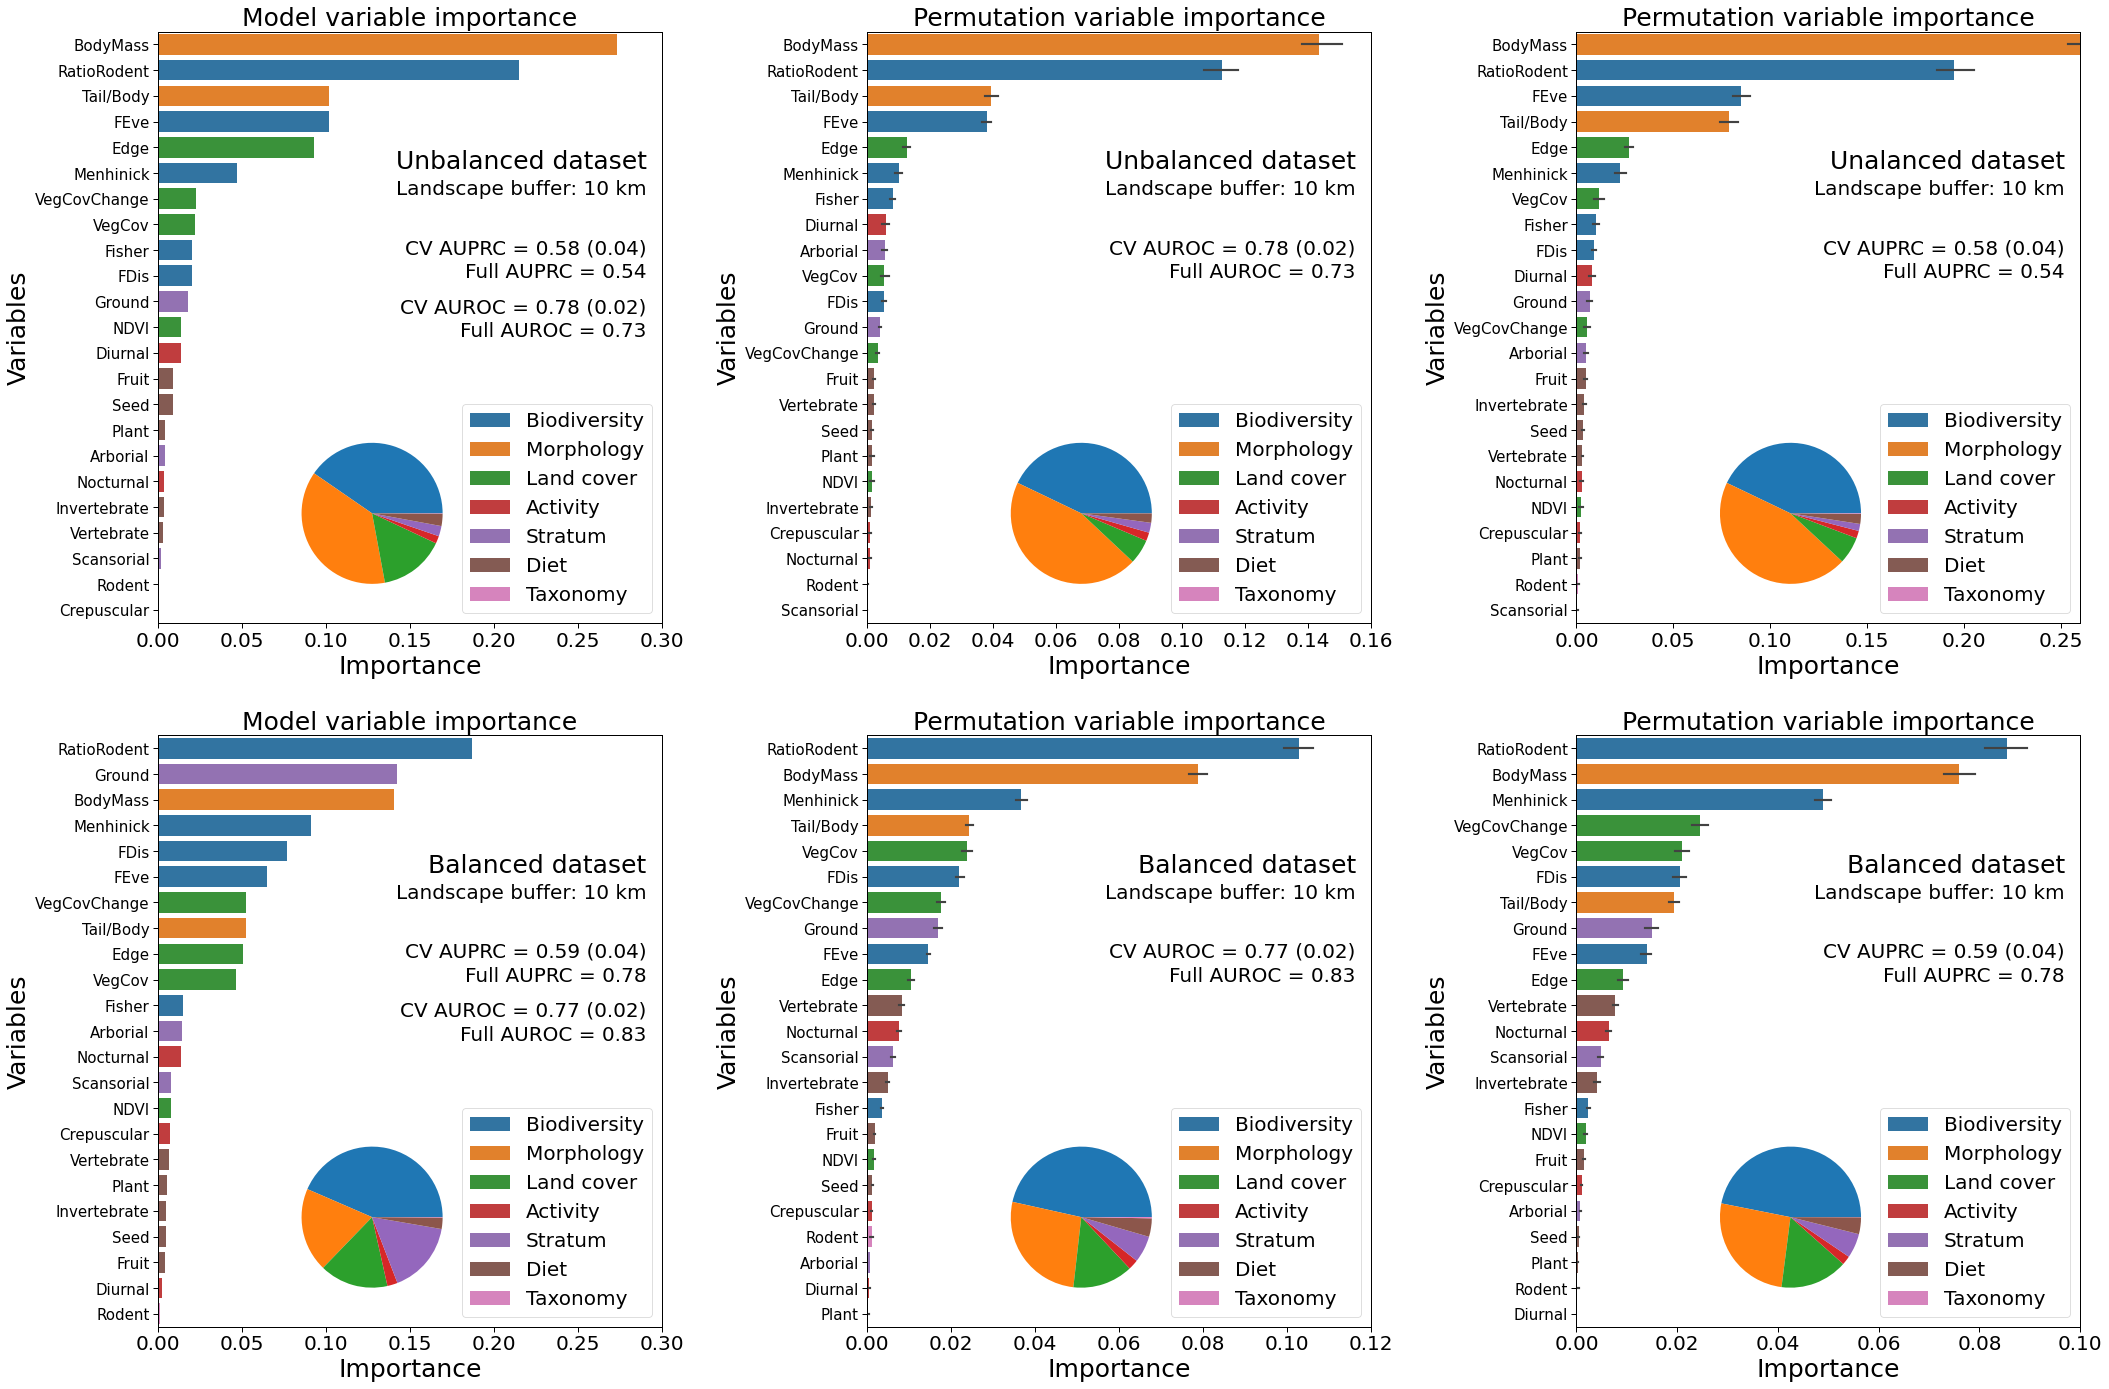

In [7]:
name='feature_importance_10km'
sns.set_context("paper", rc={"font.size":30,"axes.titlesize":25,"axes.labelsize":25})     
fig, axes = plt.subplots(2,3 , figsize=(30,20))

ax=axes[0][0]; var_imp_plot(Xnames, model_imp_10_unb, Xcategory, 'Model variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.30))
ax.text(0.97, 0.8, "Unbalanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 10 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.55, "CV AUROC = " + str(round(ROC_CV_10_unb.mean(),2)) + ' (' + str(round(ROC_CV_10_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.51, "Full AUROC = " + str(round(ROCmodel_10_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_10_unb.mean(),2)) + ' (' + str(round(AP_CV_10_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + str(round(APmodel_10_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[0][1]; var_imp_plot(Xnames, permut_imp_ROC_10_unb.importances, Xcategory, 'Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.16))
ax.text(0.97, 0.8, "Unbalanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 10 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUROC = " + str(round(ROC_CV_10_unb.mean(),2)) + ' (' + str(round(ROC_CV_10_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUROC = " + str(round(ROCmodel_10_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[0][2]; var_imp_plot(Xnames, permut_imp_AP_10_unb.importances, Xcategory, 'Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.26))
ax.text(0.97, 0.8, "Unalanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 10 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_10_unb.mean(),2)) + ' (' + str(round(AP_CV_10_unb.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + str(round(APmodel_10_unb,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)

ax=axes[1][0]; var_imp_plot(Xnames, model_imp_10_bal, Xcategory, 'Model variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.30))
ax.text(0.97, 0.8, "Balanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 10 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.55, "CV AUROC = " + str(round(ROC_CV_10_bal.mean(),2)) + ' (' + str(round(ROC_CV_10_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.51, "Full AUROC = " + str(round(ROCmodel_10_bal,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_10_bal.mean(),2)) + ' (' + str(round(AP_CV_10_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + f"{APmodel_10_bal:.2f}", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[1][1]; var_imp_plot(Xnames, permut_imp_ROC_10_bal.importances, Xcategory, 'Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.12))
ax.text(0.97, 0.8, "Balanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 10 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUROC = " + str(round(ROC_CV_10_bal.mean(),2)) + ' (' + str(round(ROC_CV_10_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUROC = " + str(round(ROCmodel_10_bal,2)), ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax=axes[1][2]; var_imp_plot(Xnames, permut_imp_AP_10_bal.importances, Xcategory, 'Permutation variable importance', ax=ax, palette=categories_col)
ax.set(xlim=(0, 0.1))
ax.text(0.97, 0.8, "Balanced dataset", ha="right", va="top", transform=ax.transAxes, fontsize=25)
ax.text(0.97, 0.75, "Landscape buffer: 10 km", ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.65, "CV AUPRC = " + str(round(AP_CV_10_bal.mean(),2)) + ' (' + str(round(AP_CV_10_bal.std(),2)) + ')', ha="right", va="top", transform=ax.transAxes, fontsize=20)
ax.text(0.97, 0.61, "Full AUPRC = " + f"{APmodel_10_bal:.2f}", ha="right", va="top", transform=ax.transAxes, fontsize=20)

fig.tight_layout()

fig.savefig(name + '.jpg')
fig.savefig(name + '.svg')
fig.savefig(name + '.pdf')

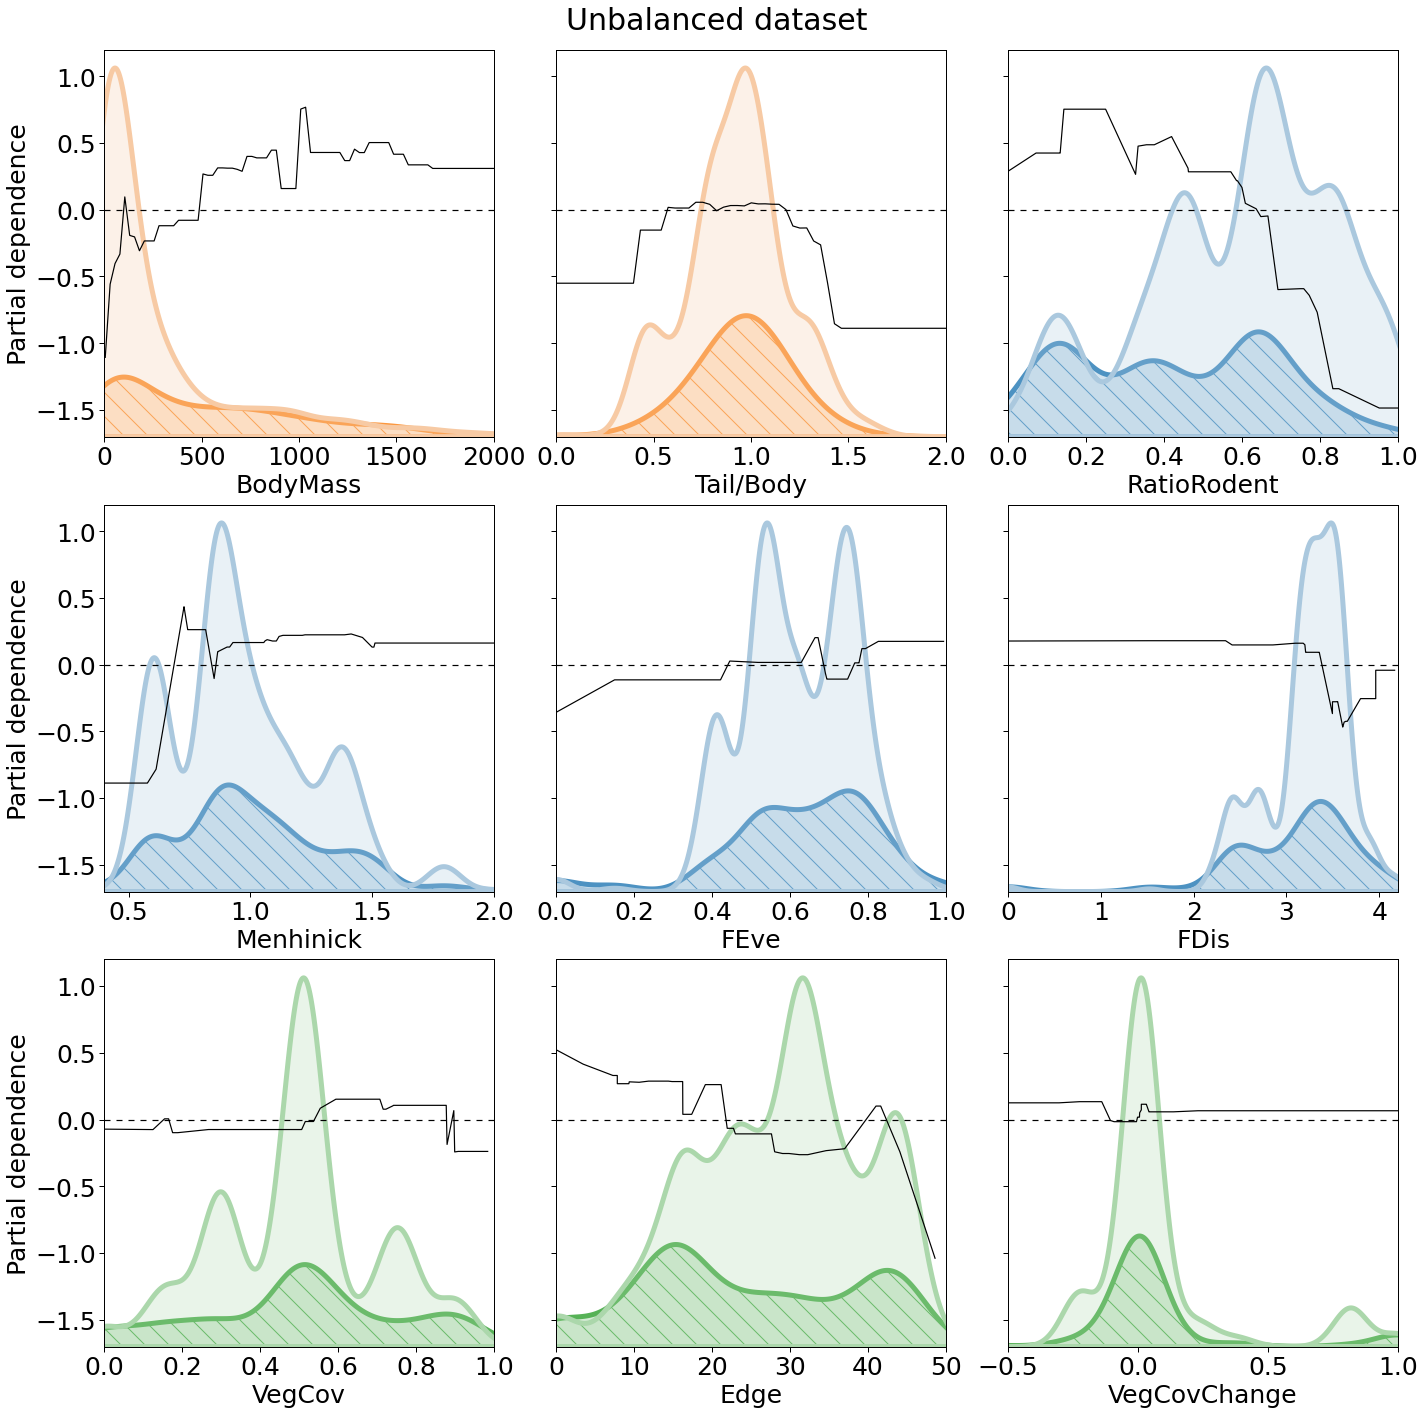

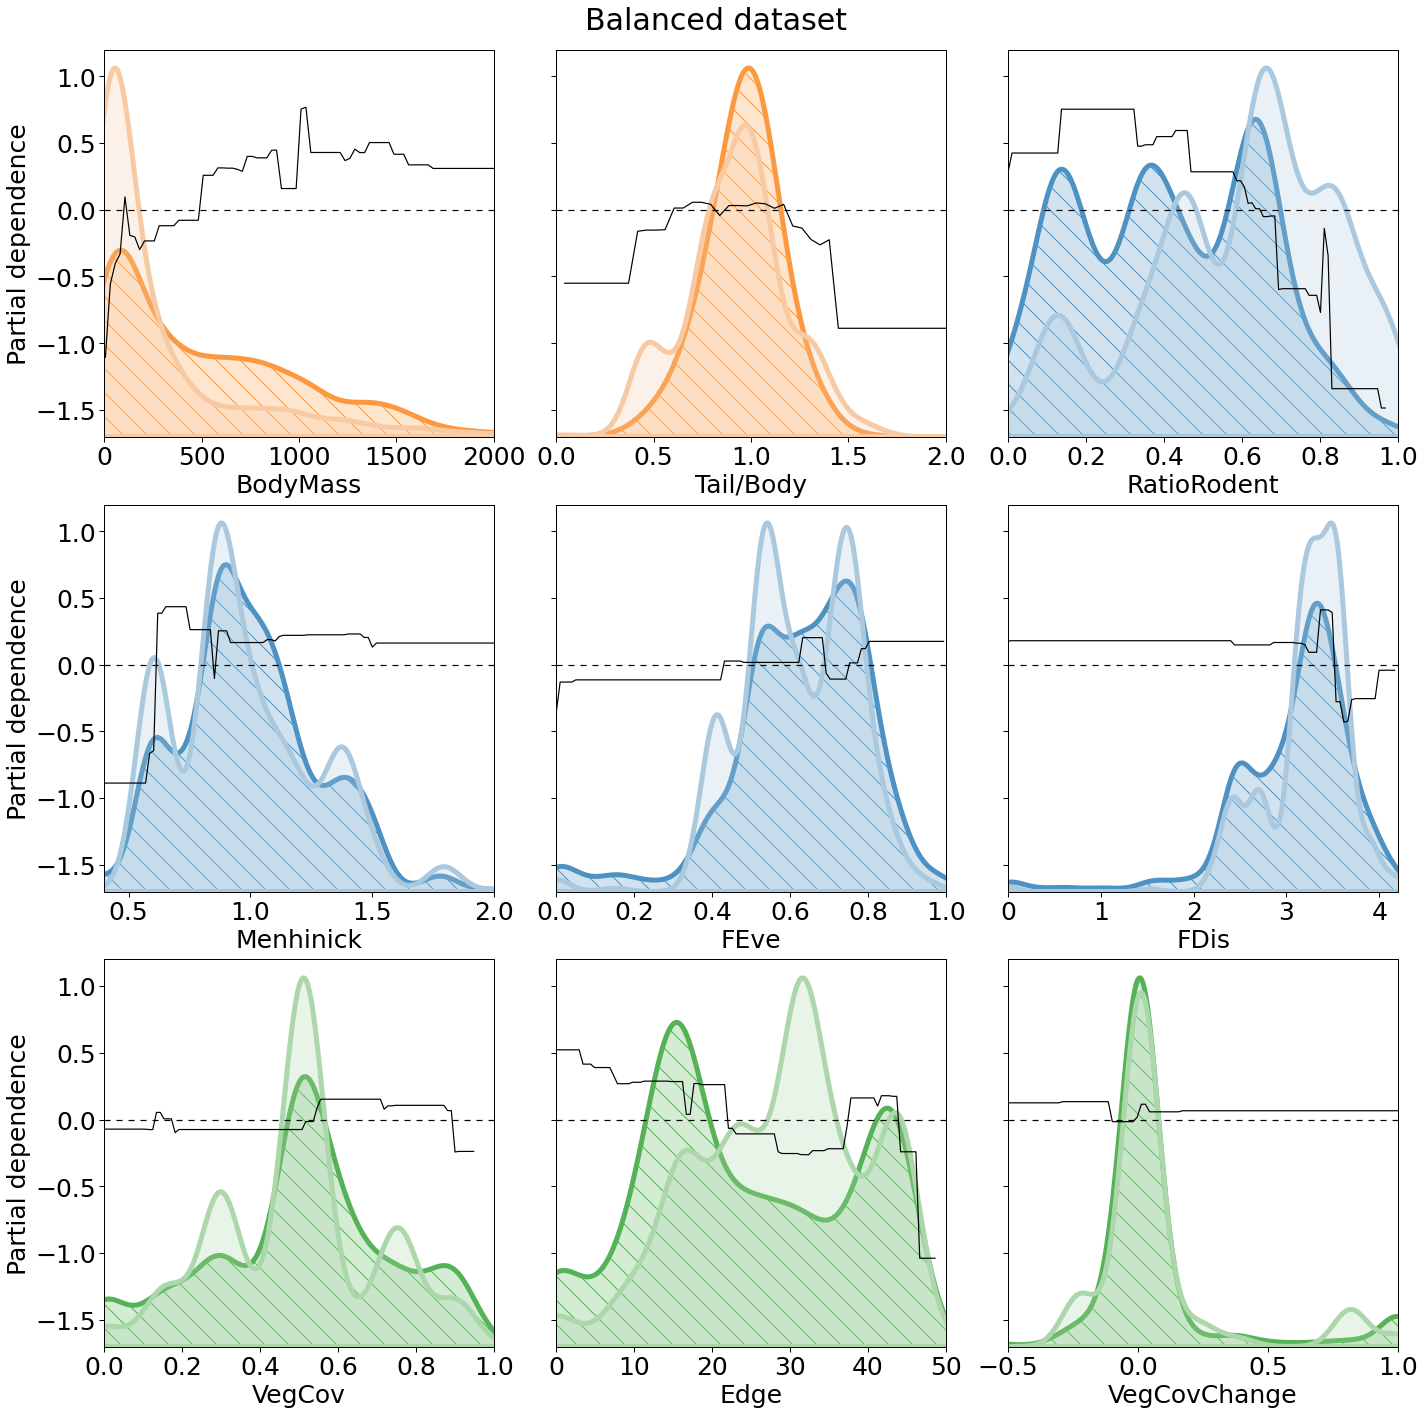

In [7]:
model_type = GradientBoostingClassifier() 
col_PDP = ['BodyMass', 'Tail/Body', 'RatioRodent', 'Menhinick', 'FEve', 'FDis', 'VegCov', 'Edge', 'VegCovChange' ] 
color = [pal[1], pal[1], pal[0],pal[0], pal[0], pal[0], pal[2], pal[2], pal[2] ] #categories_col={'Biodiversity': pal[0], 'Morphology':pal[1], 'Land cover':pal[2], 'Activity':pal[3], 'For.stratum':pal[4], 'Diet':pal[5], 'Taxonomy':pal[6]}

data_t_3 = data_ini.copy()[['infec'] + com_3 + env_3   + strat + activity + morfo + food]
data_t2_3 = data_t_3.copy()

y_3_unb = data_t_3['infec']
X_3_unb = data_t_3.drop(['infec'], axis=1)
X_3_unb.columns = X_3_unb.columns.to_series().map(dict_columns) 
data_t2_3.columns = data_t2_3.columns.to_series().map(dict_columns) 


#Xcategory_3_unb = X_3_unb.columns.to_series().map(dict_category)
model_3_unb = model_type
model_3_unb.fit(X_3_unb, y_3_unb)

X_3_bal, y_3_bal = SMOTE(random_state=1).fit_resample(X_3_unb, y_3_unb) # upsampling  
#Xcategory_3_bal = X_3_bal.columns.to_series().map(dict_category)
model_3_bal = model_type
model_3_bal.fit(X_3_bal, y_3_bal)
Xy_3_bal = X_3_bal.copy(); Xy_3_bal['Infected'] = y_3_bal

sns.set_context("paper", rc={"font.size":10,"axes.titlesize":25,"axes.labelsize":25}) 

f , ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))
h = PartialDependenceDisplay.from_estimator(model_3_unb,X_3_unb,col_PDP, line_kw={"color": "white"}, ax=ax, percentiles=(0.001,0.999)); plt.setp(h.deciles_vlines_, visible=False)

ax3=np.copy(ax)
counter=-1
for ix,iy in np.ndindex(ax.shape):
    counter+=1
    ax1=ax[ix,iy]
    ax2=ax1.twinx()
    xlim = ax1.get_xlim()
    #ax[ix,iy].set(ylim=(0., 1.))
    #sns.histplot(data=X_3_unb, x=col_PDP[counter], stat='density', color=color[counter], bins=15, binrange=xlim, ax=ax2)
    palette=sns.set_palette((sns.light_palette(color[counter],10,reverse=False))[3::4])
    #palette = sns.set_palette(sns.color_palette([color1, color2]))
    h=sns.kdeplot(data=data_t2_3, x=col_PDP[counter],  hue="Infected", fill=True, gridsize=2000, palette=palette, ax=ax2, legend=False, linewidth=5) 
    lss=['-','-']
    fss=['\\','']
    for line, ls, fs in zip(h.collections, lss, fss):
        line.set_linestyle(ls)
        line.set_hatch(fs)
    #ax[ix,iy].legend(loc="upper right", frameon=True, fontsize=20)
    #h.legend()
    #handles, labels = ax2.get_legend_handles_labels()
    #handles, labels = ax[ix,iy].get_legend_handles_labels()
    #print(labels)
    #handles, labels = ax2.get_legend_handles_labels()
    #print(labels)
    #ax[ix,iy].legend(handles=handles[1:], labels=labels[1:], title="Whatever else")
    #h.legend()
    #new_labels = ['No', 'Yes']
    #for t, l in zip(ax[ix,iy]._legend.texts, new_labels): t.set_text(l)
    ax2.get_yaxis().set_visible(False)
    ax1.set(xlim=xlim)
    ax1.tick_params(axis='y', which='major', labelsize=25)
    ax1.tick_params(axis='x', which='major', labelsize=25)
    ax3[ix,iy]=ax2.twinx()
    ax3[ix,iy].get_yaxis().set_visible(False)
    ax3[ix,iy].axhline(0, ls='--', dashes=(5,5), c='black')
h = PartialDependenceDisplay.from_estimator(model_3_unb,X_3_unb,col_PDP, line_kw={"color": "black"}, ax=ax3, percentiles=(0.001,0.999)); plt.setp(h.deciles_vlines_, visible=False)

for ii in np.arange(3):
    for jj in np.arange(3):
        ax3[ii,jj].set(ylim=[-1.7,1.2])
        ax[ii,jj].set(ylim=[-1.7,1.2])
ax[0,0].set(xlim=[0,2000])
ax[0,1].set(xlim=[0,2])
ax[0,2].set(xlim=[0,1])
ax[1,0].set(xlim=[0.4,2])
ax[1,1].set(xlim=[0,1])
ax[1,2].set(xlim=[0,4.2])
ax[2,0].set(xlim=[0,1])
ax[2,1].set(xlim=[0,50])  # MODIFICADO: New Edge
ax[2,2].set(xlim=[-0.5,1])


f.tight_layout()
f.suptitle('Unbalanced dataset', fontsize=30)
f.subplots_adjust(top=0.95)
f.savefig('PDP_3_unb.svg')
f.savefig('PDP_3_unb.jpg')
f.savefig('PDP_3_unb.pdf')

f , ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))
h = PartialDependenceDisplay.from_estimator(model_3_unb,X_3_bal,col_PDP, line_kw={"color": "white"}, ax=ax, percentiles=(0.001,0.999)); plt.setp(h.deciles_vlines_, visible=False)
ax3=np.copy(ax)
counter=-1
for ix,iy in np.ndindex(ax.shape):
    counter+=1
    ax1=ax[ix,iy]
    ax2=ax1.twinx()
    xlim = ax1.get_xlim()
    #ax[ix,iy].set(ylim=(0., 1.))
    palette=sns.set_palette((sns.light_palette(color[counter],10,reverse=False))[3::4])
    #palette = sns.set_palette(sns.color_palette([color1, color2]))
    h=sns.kdeplot(data=Xy_3_bal, x=col_PDP[counter], hue="Infected", fill=True, gridsize=2000, palette=palette, ax=ax2, legend=False, linewidth=5) 
    lss=['-','-']
    fss=['\\','']
    for line, ls, fs in zip(h.collections, lss, fss):
        line.set_linestyle(ls)
        line.set_hatch(fs)
    ax2.get_yaxis().set_visible(False)
    ax1.set(xlim=xlim)
    ax1.tick_params(axis='y', which='major', labelsize=25)
    ax1.tick_params(axis='x', which='major', labelsize=25)
    ax3[ix,iy]=ax2.twinx()
    ax3[ix,iy].get_yaxis().set_visible(False)
    ax3[ix,iy].axhline(0, ls='--', dashes=(5,5), c='black')
h = PartialDependenceDisplay.from_estimator(model_3_bal,X_3_bal,col_PDP, line_kw={"color": "black"}, ax=ax3, percentiles=(0.001,0.999)); plt.setp(h.deciles_vlines_, visible=False)

for ii in np.arange(3):
    for jj in np.arange(3):
        ax3[ii,jj].set(ylim=[-1.7,1.2])
        ax[ii,jj].set(ylim=[-1.7,1.2])
ax[0,0].set(xlim=[0,2000])
ax[0,1].set(xlim=[0,2])
ax[0,2].set(xlim=[0,1])
ax[1,0].set(xlim=[0.4,2])
ax[1,1].set(xlim=[0,1])
ax[1,2].set(xlim=[0,4.2])
ax[2,0].set(xlim=[0,1])
ax[2,1].set(xlim=[0,50])  # MODIFICADO: New Edge
ax[2,2].set(xlim=[-0.5,1])


f.tight_layout()
f.suptitle('Balanced dataset', fontsize=30)
f.subplots_adjust(top=0.95)
f.savefig('PDP_3_bal.svg')
f.savefig('PDP_3_bal.jpg')
f.savefig('PDP_3_bal.pdf')